# Experiment: ADLO (v3b) - Spatial Layer Testing
This notebook focuses on low-level testing of some of the layer types.

In particular:
* How do gradients flow through the layers?
* How efficient are they to train, compared to other options?

Learnings:
* Effect of different reduction methods against loss
  * Calculating MSE loss as `mse(y_true, y_pred, axis=-1)` gives you a (b x h x w) loss tensor with large gradients. eg: in the range -6000..+6000.
  * Calculating loss as `tf.reduce_sum(mse(y_true, y_pred, axis=-1))` gives identical results.
  * Calculating loss as `tf.reduce_mean(mse(y_true, y_pred, axis=-1))` gives much smaller scaled gradients typically much smaller than -1.0..+1.0.
  * There seems to be some relationship between the magnitude of the loss, the size of the tensor, and the range of gradients, but I'm not sure what it is.

|Setup|Loss|Kernel gradients|Image gradients|
|--|--|--|---|
|reduce_mean loss, simple conv2d layer|1.05|+/- 0.0075|+/- 1e-6|
|reduce_sum loss, simple conv2d layer|733,829|+/- 6000|+/- 0.7|
|reduce_mean loss, conv2d+globalmaxpool, spotty input gradient coverage|1.9|+/- 0.2|+/- 0.002|
|reduce_sum loss, conv2d+globalmaxpool, spotty input gradient coverage|63.7|+/- 6|+/- 0.05|

* Conv2D
  * Conv + MaxPool layers suffer from a vignetting effect on the backprop'd gradients. Surprisingly, this is worst when using 'valid' padding (ie: no padding). In contrast, 'same' padding is quite adept at restricting the vignet to just the outermost edge, even on the earliest layers.
* MaxPool2D
  * Each max-pool patch selects just _one_ of its 2x2 inputs (or whatever patch size). If MaxPool layers are run consecutively, on their own this results in "dark spots" in the earlier layers. Those can only be recovered from via other data sources:
    * batch - provides 32 samples instead of 1, so randomly selects 32 positions (with replacement) out of all possible positions and ensures that gradients propagate back to those positions.
    * conv - pools information from surrounding positions, so gradients propagate back to a wider area. This is quite effective at preventing "dark spots".
  * However, MaxPool also causes aliasing effects.
* GlobalMaxPool
  * Given 32 input images in a batch, and 32 output channels, and assuming randomness, this gives 32*32 = 1024 separate locations for max value. Each location influences a 3x3 patch around its location.
  * So you get 1024 little patches scattered around the image, covering about 41% of all pixels in a 149x149 image.
  * The kernel itself is fully populated with gradients, with good differentiation.
  * The biggest problem is that it probably leads to vanishing gradients as the mean backprop gradient is close to zero.
* GlobalAvePool
  * Wierdly worse than GlobalMaxPool.
  * Kernel gets different gradients for each channel (probably based on their initial random state), but with no differentiation by position. The 3x3 shape acts like a single value.
  * The image gets a uniform gradient across its entire surface, varying only on the channel axis.
* PositionwiseMaxPool2D
  * If only output spatial values are subsequently used, and original semantic features discarded, then there is **no kernel gradient** and **no backprop gradient**. The problem is that the features are only used in the conditional, with no other influence on the loss - and the conditional is not differentiable. So there's no informational pathway for the features.

Anti-aliasing and Checkerboard artifacts:
* Conv layers produce aliasing artifacts in the backprop gradients. It is worst when combined with MaxPool or strided convolutions, as they explicitly add in high-frequency aliasing effects. But even just conv layers alone cause this.
* Zhang, R. (2019). Making Convolutional Networks Shift-Invariant Again. ICML. https://doi.org/10.48550/arXiv.1904.11486
* Odena, et al. (2016). Deconvolution and Checkerboard Artifacts. Distill. http://doi.org/10.23915/distill.00003


In [ ]:
# Clone repo and load its modules
import os
import sys
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull
sys.path.append('repo')

# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout 550ac65
sys.path.append('training-instrumentation-toolkit')

from general_utils import display_history
import lds
import slam_models
import slam_data
import slam_operations
import train_instrumentation as tinstr
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_data)
reload(slam_operations)

Cloning into 'repo'...
remote: Enumerating objects: 936, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 936 (delta 30), reused 29 (delta 29), pack-reused 903 (from 1)
Receiving objects: 100% (936/936), 125.36 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (516/516), done.
Updating files: 100% (59/59), done.
Already up to date.
Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1645, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 1645 (delta 135), reused 109 (delta 57), pack-reused 1440 (from 2)
Receiving objects: 100% (1645/1645), 247.86 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (992/992), done.
Updating files: 100% (23/23), done.
Note: switching to '550ac65'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state wit

<module 'slam_operations' from '/content/repo/slam_operations.py'>

In [ ]:
# Load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import IPython.display as idisplay
import os
import sys
import math
import tqdm
import time
from timeit import default_timer as timer
import cv2
import re

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.18.0
Keras version: 3.8.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


## Helpful Functions

## Custom Layers

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


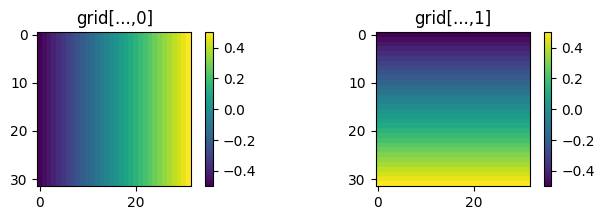

In [ ]:
# Based on R. Liu et al., “An Intriguing Failing of CNNs and the CoordConv Solution,” NeurIPS 2018
# https://arxiv.org/abs/1807.03247
class CoordGrid2D(layers.Layer):
    """
    Returns a (batch_size, height, width, 2) tensor with a grid of (x,y) coordinates.
    Generally this will be subsequently concatenated with the input tensor.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid:
        # - x_coords: shape (width,) from -0.5 to 0.5
        # - y_coords: shape (height,) from -0.5 to 0.5
        x_coords = tf.linspace(-0.5, 0.5, width)
        y_coords = tf.linspace(-0.5, 0.5, height)

        # Use meshgrid to get 2D coordinate maps
        # - xx, yy shape => (height, width)
        xx, yy = tf.meshgrid(x_coords, y_coords)

        # Reshape for appending as channels
        xx = tf.expand_dims(xx, axis=-1)  # (height, width, 1)
        yy = tf.expand_dims(yy, axis=-1)  # (height, width, 1)

        # Tile across batch dimension
        xx_tiled = tf.tile(tf.expand_dims(xx, 0), [batch_size, 1, 1, 1])
        yy_tiled = tf.tile(tf.expand_dims(yy, 0), [batch_size, 1, 1, 1])

        # Output as grid with 2-channels
        # output.shape => [batch_size, height, width, 2]
        output = tf.concat([xx_tiled, yy_tiled], axis=-1)
        return output

# demo
input = tf.keras.Input(shape=(32, 32, 3))
cg = CoordGrid2D()(input)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
print(f"actual output: {type(cg)}, shape: {cg.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()
plt.show()

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 33, 32, 2)


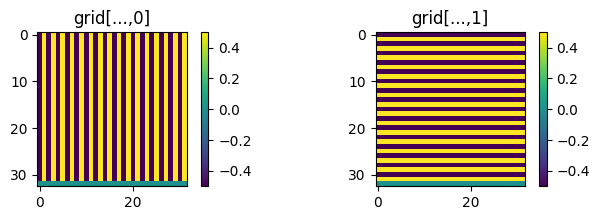

In [ ]:
class StrideGrid2D(layers.Layer):
    """
    Returns a (batch_size, height, width, 2) tensor with a grid of (x,y) coordinates.
    Coordinates are aligned to the strides of an assumed subsequent pooling layer,
    and indicate the relative position of the cell in the pool, relative to the
    pool's centre.
    For example, with stride=2, each 2x2 sub-grid has coordinates:
       [[-0.5,-0.5], [+0.5,-0.5]],
        [-0.5,+0.5], [+0.5,+0.5]].

    Generally this will be subsequently concatenated with the input tensor
    before applying a position-wise pooling operation.
    """
    def __init__(self, strides=2, **kwargs):
        super().__init__(**kwargs)
        self.strides = (strides, strides) if np.isscalar(strides) else strides

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid patch:
        # - x_coords: shape (stride_width,) from -0.5 to 0.5
        # - y_coords: shape (stride_height,) from -0.5 to 0.5
        # - xx, yy shape => (stride_height, stride_width)
        # - concatted: (stride_height, stride_width, 2)
        stride_height, stride_width = self.strides
        x_coords = tf.linspace(-0.5, 0.5, stride_width)
        y_coords = tf.linspace(-0.5, 0.5, stride_height)
        xx, yy = tf.meshgrid(x_coords, y_coords)
        grid = tf.concat([tf.expand_dims(xx, axis=-1), tf.expand_dims(yy, axis=-1)], axis=-1)

        # Tile across all patches in image
        # - Tile, then pad if needed
        # - (width, height, 2)
        patch_count_x = width // stride_width
        patch_count_y = height // stride_height
        x_pad = tf.cast(width - patch_count_x * stride_width, tf.int32)
        y_pad = tf.cast(height - patch_count_y * stride_height, tf.int32)
        tiled = tf.tile(grid, [patch_count_x, patch_count_y, 1])
        paddings = tf.stack([
            tf.stack([0, y_pad]),
            tf.stack([0, x_pad]),
            tf.stack([0, 0])
        ])
        tiled = tf.pad(tiled, paddings, 'CONSTANT')

        # Tile across batch dimension
        output = tf.tile(tf.expand_dims(tiled, 0), [batch_size, 1, 1, 1])
        return output

input = tf.keras.Input(shape=(32, 32, 3))
cg = StrideGrid2D()(input)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

input = tf.zeros((1, 33, 32, 3))
cg = StrideGrid2D(strides=2)(input)
print(f"actual output: {type(cg)}, shape: {cg.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()
plt.show()

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


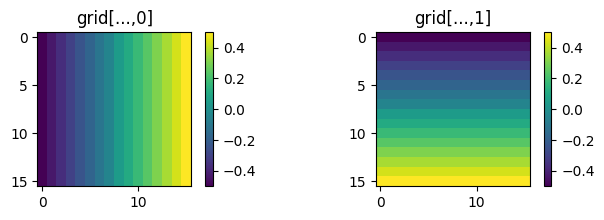

In [ ]:
class PositionwiseMaxPool2D(tf.keras.layers.Layer):
    """
    Pooling operation that selects all channels from the same position as a single unit.
    Positions are chosen by arg-max over a reduction operation (sum-of-squares).
    Use channel_weights to exclude some channels from the reduction.
    """

    def __init__(self, pool_size=(2, 2), strides=None, channel_weights=None, **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.channel_weights = channel_weights

    def call(self, inputs):
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))
        ksize = self.pool_size
        strides = self.strides

        # Extract 2x2 patches: shape (B, H//2, W//2, 2, 2, C)
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, strides[0], strides[1], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_shape = tf.shape(patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        patches = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute reduction: (B, out_h, out_w, 4)
        # - using sum-of-squares, which is equivalent to a norm() once argmax is applied
        if self.channel_weights is None:
          norms = tf.reduce_sum(tf.square(patches), axis=-1)
        else:
          norms = tf.reduce_sum(tf.square(patches) * self.channel_weights, axis=-1)

        # Argmax to find winning positions: (B, out_h, out_w)
        indices = tf.argmax(norms, axis=-1, output_type=tf.int32)

        # Gather the full vectors corresponding to max-norm positions
        one_hot = tf.one_hot(indices, depth=ksize[0]*ksize[1])  # shape: (B, out_h, out_w, 4)
        one_hot = tf.expand_dims(one_hot, axis=-1)              # shape: (B, out_h, out_w, 4, 1)
        output = tf.reduce_sum(one_hot * patches, axis=-2)      # shape: (B, out_h, out_w, C)

        return output

input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
#cg = StrideGrid2D()(input)
mp = PositionwiseMaxPool2D()(cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

In [ ]:
# PositionwiseMaxPool2D tests

# Combining coord grid with channel_mask
input = tf.constant([[
    [[0.5, 0.5, 0.3], [0.1, 0.2, 0.3], [0.5, 0.3, 0.5], [0.7, 0.8, 0.9]],
    [[0.4, 0.3, 0.5], [0.3, 0.3, 0.3], [0.4, 0.3, 0.5], [0.3, 0.3, 0.3]],
    [[0.1, 0.2, 0.3], [0.0, 0.0, 0.3], [0.3, 0.5, 0.5], [0.6, 0.6, 0.7]],
    [[0.2, 0.3, 0.2], [0.0, 0.0, 0.3], [0.4, 0.3, 0.5], [0.5, 0.6, 0.5]]
]])
expected1 = tf.constant([[
    [[0.5, 0.5, 0.3, -0.5, -0.5], [0.7, 0.8, 0.9, +0.5, -0.5]],
    [[0.2, 0.3, 0.2, -0.5, +0.5], [0.6, 0.6, 0.7, +0.5, 1/6.]]
]])
coords = CoordGrid2D()(input)
x = layers.Concatenate()([input, coords])
x = PositionwiseMaxPool2D(channel_weights=[1, 1, 1, 0, 0])(x)
assert np.allclose(x.numpy(), expected1.numpy())

# Combining stride grid with channel_mask
expected2 = tf.constant([[
    [[0.4, 0.3, 0.5, -0.5, +0.5], [0.7, 0.8, 0.9, +0.5, -0.5]],
    [[0.1, 0.2, 0.3, -0.5, -0.5], [0.6, 0.6, 0.7, +0.5, -0.5]],
]])
coords = StrideGrid2D()(input)
x = layers.Concatenate()([input, coords])
x = PositionwiseMaxPool2D(channel_weights=[0, 0, 1, 0, 0])(x)
assert np.allclose(x.numpy(), expected2.numpy())

In [ ]:
# Suggested by ChatGPT
# - This variant treats the entire image as heatmaps, one heatmap for each channel.
# - And identifies a single centre point.
# - Nice on the face of it, but not clear how to pass the spatial results down through further down-scaling blocks.
# TODO could turn into complete layer
def spatial_softmax(activations):
    # activations: (B, H, W, C)
    shape = tf.shape(activations)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]

    # Reshape to (B, H*W, C)
    flat = tf.reshape(activations, [B, H * W, C])
    softmax = tf.nn.softmax(flat, axis=1)

    # Create coordinate grid
    x_coords = tf.linspace(-1.0, 1.0, W)
    y_coords = tf.linspace(-1.0, 1.0, H)
    x_grid, y_grid = tf.meshgrid(x_coords, y_coords)
    x_grid = tf.reshape(x_grid, [-1])
    y_grid = tf.reshape(y_grid, [-1])

    # Multiply and sum: expected x and y
    expected_x = tf.reduce_sum(softmax * x_grid[tf.newaxis, :, tf.newaxis], axis=1)
    expected_y = tf.reduce_sum(softmax * y_grid[tf.newaxis, :, tf.newaxis], axis=1)

    # Output shape: (B, 2*C)
    return tf.concat([expected_x, expected_y], axis=-1)


symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


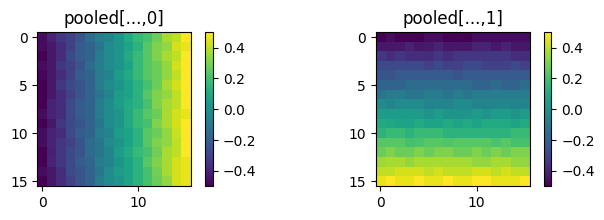

In [ ]:
class AttentionPool2D(tf.keras.layers.Layer):
    """
    2D downsampling layer that computes a soft-argmax from one input
    to attend to the second input.
    Typically used for softmax-weighted pooling of positional inputs, based
    on the strength of the feature vectors.

    Both inputs must have the same shape (B, H, W, C). Operates channel-wise.
    Channels from each input are paired up, in sequence.

    Output shape: (B, pooled_H, pooled_w, C).
    """

    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = padding.upper()

    def call(self, keys, values):
        batch_size, height, width, channels = tf.unstack(tf.shape(keys))
        tf.assert_equal(tf.shape(keys), tf.shape(values), "Input tensors must have identical shape", summarize=4)
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        key_patches = tf.image.extract_patches(
            images=keys,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        value_patches = tf.image.extract_patches(
            images=values,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(key_patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        key_patches   = tf.reshape(key_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])
        value_patches = tf.reshape(value_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute softmax-weighted mean of values, shape: (B, out_h, out_w, C)
        attention_scores = tf.nn.softmax(key_patches, axis=-2)
        output = tf.reduce_sum(attention_scores * value_patches, axis=-2)
        return output

# check with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = StrideGrid2D()(input)
cg = CoordGrid2D()(input)
mp = AttentionPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# check with concrete values
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
mp = AttentionPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (features): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


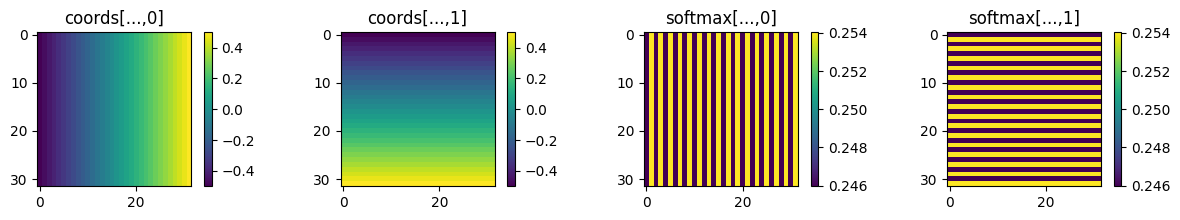

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


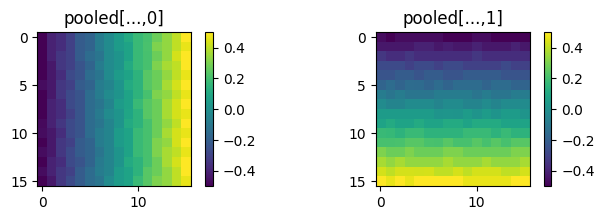

In [ ]:
# Breaks out the steps of AttentionPool2D for easier interpretability.
class StridedSoftmax2D(tf.keras.layers.Layer):
    """
    Applies softmax to values within stride-patches, channel-wise.
    """

    def __init__(self, pool_size=(2, 2), strides=None, **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = 'valid'.upper()  # can only do if using 'valid' padding

        if self.pool_size != self.strides:
            raise ValueError("pool_size and strides must be the same")

    def call(self, input):
        batch_size, height, width, channels = tf.unstack(tf.shape(input))
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        # Then reshape to (B, out_h, out_w, 4, C)
        patches = tf.image.extract_patches(
            images=input,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(patches)
        out_h, out_w = patch_shape[1], patch_shape[2]
        patches = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute softmax
        # Then reshape back to original (B, H, W, C)
        # Compute softmax-weighted mean of values, shape: (B, out_h, out_w, C)
        patches = tf.nn.softmax(patches, axis=-2)

        # Convert back to original shape
        # - only possible when strides=pool_size and padding=valid
        output = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0], ksize[1], channels])
        output = tf.transpose(output, [0, 1, 3, 2, 4, 5])  # eg: (B, H//2, 2, W//2, 2, C)
        output = tf.reshape(output, [batch_size, height, width, channels])

        return output

class DotPool2D(tf.keras.layers.Layer):
    """
    2D downsampling layer that combines the values between two inputs via a flattened dot-product
    applied patch-wise and channel-wise. Wordedly differently, it applies a weighted sum,
    where the first input provides the weights and the second input provides the values.
    However, you could equally phrase them the other way around.

    Both inputs must have the same shape (B, H, W, C). Operates channel-wise.
    Channels from each input are paired up, in sequence.

    Output shape: (B, pooled_H, pooled_w, C).
    """

    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = padding.upper()

    def call(self, keys, values):
        batch_size, height, width, channels = tf.unstack(tf.shape(keys))
        tf.assert_equal(tf.shape(keys), tf.shape(values), "Input tensors must have identical shape", summarize=4)
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        key_patches = tf.image.extract_patches(
            images=keys,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        value_patches = tf.image.extract_patches(
            images=values,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(key_patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        key_patches   = tf.reshape(key_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])
        value_patches = tf.reshape(value_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute dotted sum of values, shape: (B, out_h, out_w, C)
        output = tf.reduce_sum(key_patches * value_patches, axis=-2)
        return output

# check with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = StrideGrid2D()(input)
cg = CoordGrid2D()(input)
features = StridedSoftmax2D()(features)
mp = DotPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# check with concrete values
input = tf.zeros((1, 32, 32, 3))
#features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
coords = CoordGrid2D()(input)
features = StridedSoftmax2D()(coords)
print(f"actual output (features): {type(features)}, shape: {features.shape}")

plt.figure(figsize=(15,2))
plt.subplot(1,4,1)
plt.title("coords[...,0]")
plt.imshow(coords[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,2)
plt.title("coords[...,1]")
plt.imshow(coords[0,:,:,1])
plt.colorbar()

plt.subplot(1,4,3)
plt.title("softmax[...,0]")
plt.imshow(features[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,4)
plt.title("softmax[...,1]")
plt.imshow(features[0,:,:,1])
plt.colorbar()
plt.show()

# check with concrete values
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
features = StridedSoftmax2D()(features)
mp = DotPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

## Layer analysis through gradients

Input:  (32, 149, 149, 1)
Output: (32, 147, 147, 32)
Loss:   1.0636378526687622 <- 0.2527198791503906..2.8647537231445312
Parameter gradients (2): [TensorShape([3, 3, 1, 32]), TensorShape([32])]
Input gradients: (32, 149, 149, 1)
Layer gradients (1): [TensorShape([32, 147, 147, 32])]
Layer outputs (1): [TensorShape([32, 147, 147, 32])]


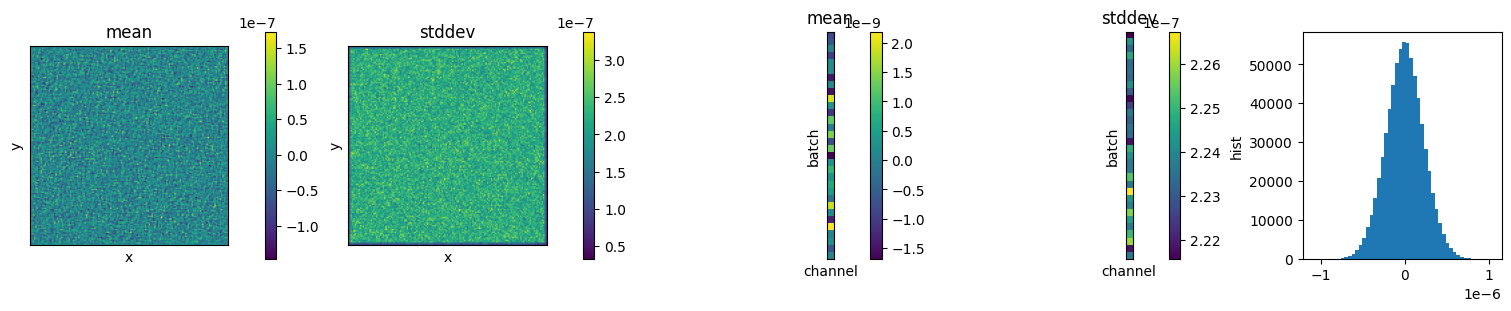

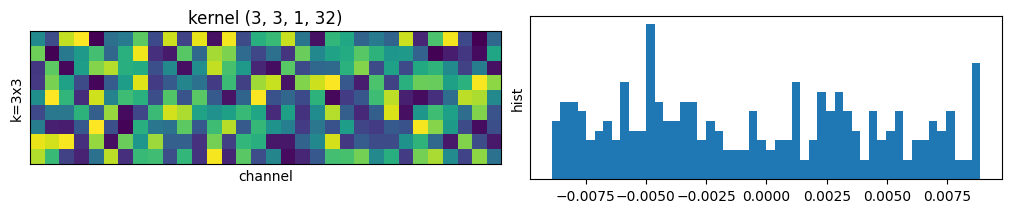

Input:  (32, 149, 149, 1)
Output: (32, 147, 147, 1)
Loss:   1.9572731256484985 <- 2.7853275241795927e-12..51.73842239379883
Parameter gradients (2): [TensorShape([3, 3, 1, 1]), TensorShape([1])]
Input gradients: (32, 149, 149, 1)
Layer gradients (1): [TensorShape([32, 147, 147, 1])]
Layer outputs (1): [TensorShape([32, 147, 147, 1])]


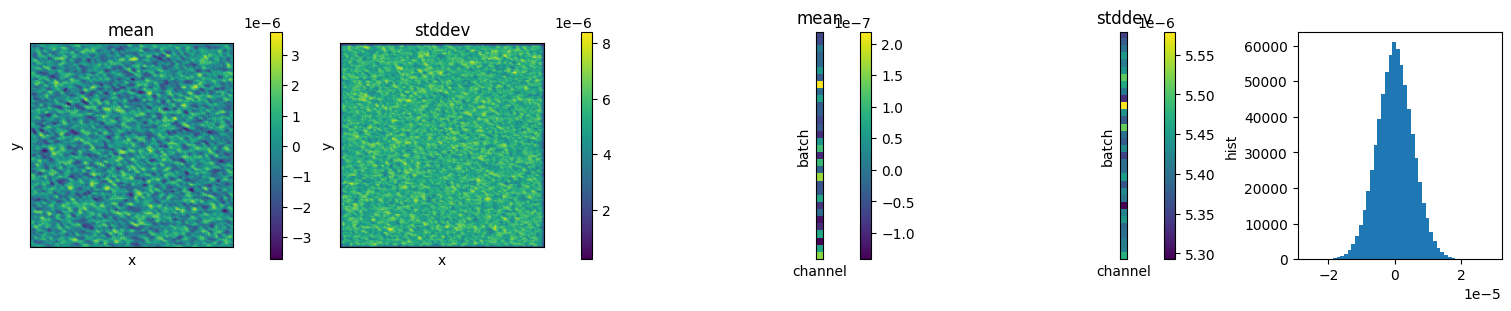

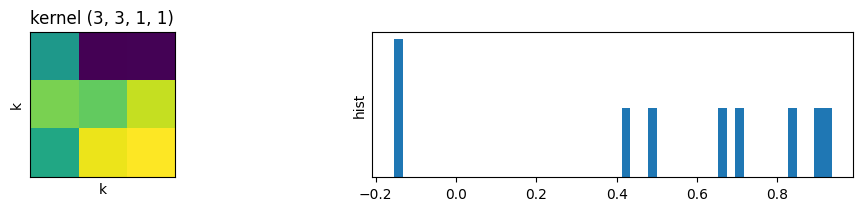

In [ ]:
def gradients_for(layer, inputs=None):
  """
  Takes a single layer or a small model representing a block, and computes the gradients w.r.t its parameters
  and w.r.t its inputs. In other words, it computes the parameter gradients and the backprop for this layer
  or block as it would be in a larger model.

  Returns:
   - parameter_gradients, input_gradients
  """
  # randomly generate input batch, if needed
  if inputs is None:
    inputs = tf.keras.Input(shape=(149, 149, 1))
  if isinstance(inputs, tf.Tensor):
    symbolic_input = tf.keras.Input(shape=inputs.shape)
    actual_input = inputs
  else:
    shape = inputs.shape
    if shape[0] is None:
      shape = (32,) + shape[1:]
    symbolic_input = inputs
    actual_input = tf.random.normal(shape=shape)
  print(f"Input:  {actual_input.shape}")

  # prepare model
  if isinstance(layer, tf.keras.layers.Layer):
    outputs = layer(symbolic_input)
    model = tf.keras.Model(inputs=symbolic_input, outputs=outputs)
  elif isinstance(layer, tf.keras.Model):
    model = layer
  else:
    model = tf.keras.Model(inputs=symbolic_input, outputs=layer)

  # prepare model with layers split out
  model_outputs = model.outputs
  if not isinstance(model_outputs, list):
    model_outputs = [model_outputs]
  monitoring_model = tf.keras.Model(
      inputs=tinstr._original_inputs(model),
      outputs=model_outputs + [layer.output for layer in model.layers])

  # randomly generate expected output
  shape = model.output.shape
  shape = (32,) + shape[1:]
  expected_output = tf.random.normal(shape=shape)
  print(f"Output: {expected_output.shape}")

  # calculate gradients
  # - note: layer_outputs includes Input, because it's created as an explicit Input layer
  with tf.GradientTape() as tape:
    tape.watch(actual_input)
    monitoring_outputs = monitoring_model(actual_input)
    y_pred = monitoring_outputs[0]
    layer_outputs = monitoring_outputs[1:]
    loss_t = tf.keras.losses.MSE(expected_output, y_pred)
    loss = tf.reduce_mean(loss_t)
  print(f"Loss:   {loss} <- {tf.reduce_min(loss_t)}..{tf.reduce_max(loss_t)}")
  if np.isnan(loss):
    raise ValueError("loss is NaN")
  gradients = tape.gradient(loss, model.trainable_weights + layer_outputs)
  parameter_gradients = gradients[:len(model.trainable_weights)]
  input_gradients = gradients[len(model.trainable_weights)]
  layer_gradients = gradients[len(model.trainable_weights)+1:]
  layer_outputs = layer_outputs[1:]  # drop Input

  # log info
  def _shape_of(t):
    return None if t is None else t.shape
  print(f"Parameter gradients ({len(parameter_gradients)}): {[_shape_of(g) for g in parameter_gradients]}")
  print(f"Input gradients: {_shape_of(input_gradients)}")
  print(f"Layer gradients ({len(layer_gradients)}): {[_shape_of(g) for g in layer_gradients]}")
  print(f"Layer outputs ({len(layer_outputs)}): {[_shape_of(g) for g in layer_outputs]}")

  return parameter_gradients, input_gradients, layer_gradients, layer_outputs

def _add_plot_hist(data, bins=10):
  # efficient equivalent of plt.hist()
  counts, bin_edges = np.histogram(tf.reshape(data, [-1]), bins=bins)
  bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
  bin_widths = np.diff(bin_edges)
  plt.bar(bin_centers, counts, width=bin_widths)

def plot_image_batch(images, title=None):
  """
  Plots a batch of images.
  """
  b, h, w, ch = images.shape

  plt.figure(figsize=(15,3), layout='constrained')

  # front-view (position-wise)
  if ch == 3:
    # RGB images
    image_mean = tf.reduce_mean(images, axis=0)
    image_std = tf.math.reduce_std(images, axis=0)
  else:
    # flattened gray-scale images
    image_mean = tf.reduce_mean(images, axis=[0, 3])
    image_std = tf.math.reduce_std(images, axis=[0, 3])

  plt.subplot(1,5,1)
  plt.title("mean" if title is None else f"{title}\nmean")
  plt.imshow(image_mean)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(1,5,2)
  plt.title("stddev")
  plt.imshow(image_std)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  # side-view (batch, channel-wise)
  image_mean = tf.reduce_mean(images, axis=[1, 2])
  image_std = tf.math.reduce_std(images, axis=[1, 2])

  plt.subplot(1,5,3)
  plt.title("mean")
  plt.imshow(image_mean)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("channel")
  plt.ylabel("batch")
  plt.colorbar()

  plt.subplot(1,5,4)
  plt.title("stddev")
  plt.imshow(image_std)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("channel")
  plt.ylabel("batch")
  plt.colorbar()

  # normal plt.hist() can't cope with such large tensors
  # (but using np.histogram() works efficiently)
  plt.subplot(1,5,5)
  _add_plot_hist(images, bins=50)
  plt.ylabel("hist")

def plot_kernel(kernel, title=None):
  """
  Plot an actual kernel or kernel gradients.
  """
  h, w, in_ch, out_ch = kernel.shape

  if in_ch == 1:
    plt.figure(figsize=(10,2), layout='constrained')

    plt.subplot2grid((h,2), (0, 0), rowspan=h)
    shape_disp = tuple(kernel.shape.as_list())
    plt.title(f"kernel {shape_disp}" if title is None else f"{title}\nkernel {shape_disp}")
    if out_ch == 1:
      plt.imshow(kernel[:, :, 0, 0])
      plt.xticks([])
      plt.yticks([])
      plt.xlabel("k")
      plt.ylabel("k")
    else:
      data = tf.reshape(kernel, [-1, out_ch])
      plt.imshow(data)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel("channel")
      plt.ylabel(f"k={h}x{w}")
  else:
    raise ValueError("Don't know what to do with multiple in-channels yet")
    # todo maybe take inspiration from "1, 2, ..., N" patterns, and list the
    # first two and last in_ch
    #   plt.subplot2grid((h,2), (0, 0), rowspan=h)

  plt.subplot2grid((h,2), (0, 1), rowspan=h)
  #plt.hist(tf.reshape(kernel, [-1]), bins=50)
  _add_plot_hist(kernel, bins=50)
  plt.yticks([])
  plt.ylabel("hist")
  plt.show()

# simple example: conv2D only
parameter_gradients, input_gradients, _, _ = gradients_for(layers.Conv2D(filters=32, kernel_size=(3,3)))
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

# simple example: conv2D only - only 1 filter
parameter_gradients, input_gradients, _, _ = gradients_for(layers.Conv2D(filters=1, kernel_size=(3,3)))
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

Input:  (32, 15, 15, 1)
Output: (32, 1, 1, 1)
Loss:   1.5441334247589111 <- 0.001601089141331613..7.210817337036133
Parameter gradients (14): [TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1])]
Input gradients: (32, 15, 15, 1)
Layer gradients (7): [TensorShape([32, 13, 13, 1]), TensorShape([32, 11, 11, 1]), TensorShape([32, 9, 9, 1]), TensorShape([32, 7, 7, 1]), TensorShape([32, 5, 5, 1]), TensorShape([32, 3, 3, 1]), TensorShape([32, 1, 1, 1])]
Layer outputs (7): [TensorShape([32, 13, 13, 1]), TensorShape([32, 11, 11, 1]), TensorShape([32, 9, 9, 1]), TensorShape([32, 7, 7, 1]), TensorShape([32, 5, 5, 1]), TensorShape([32, 3, 3, 1]), TensorShape([32, 1, 1, 1])]


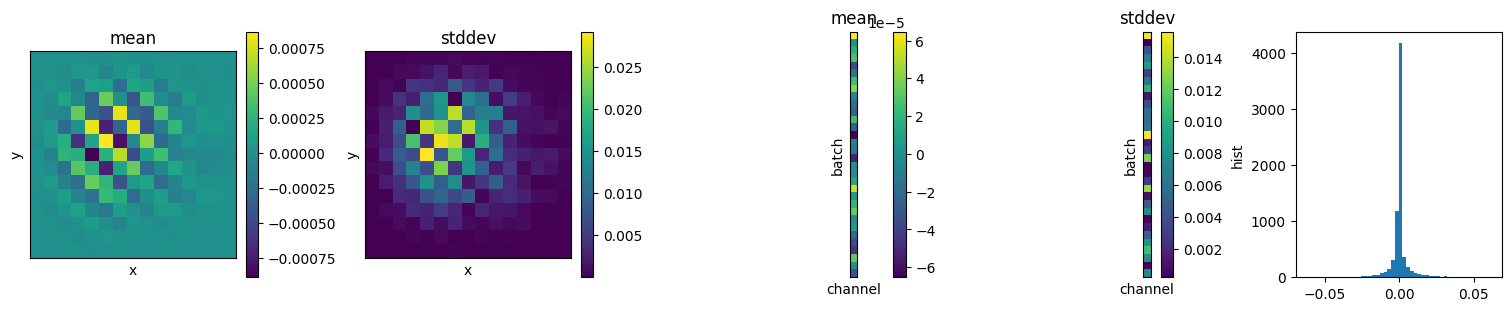

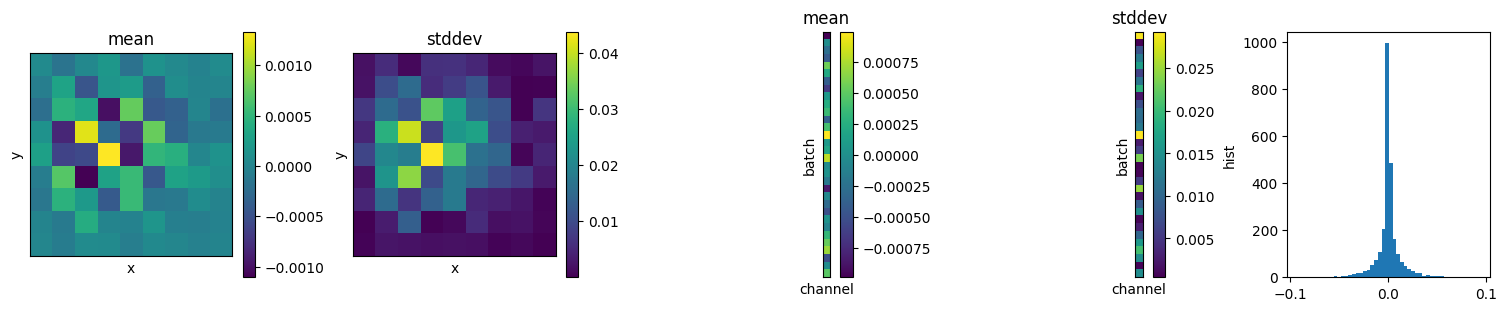

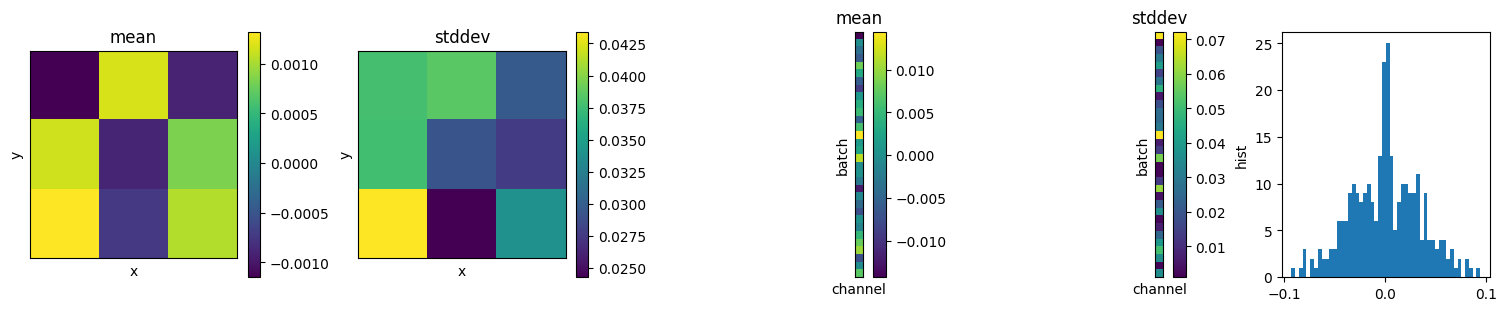

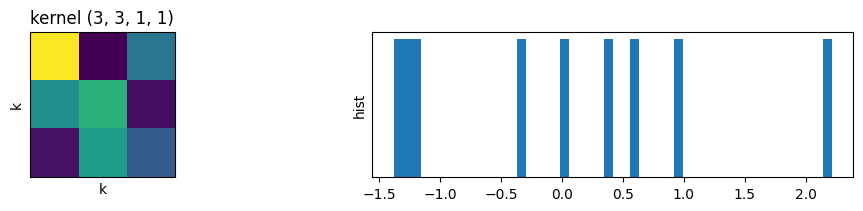

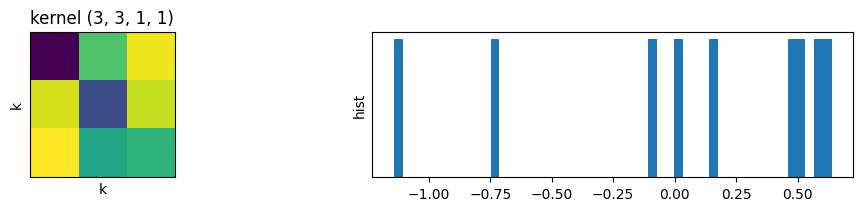

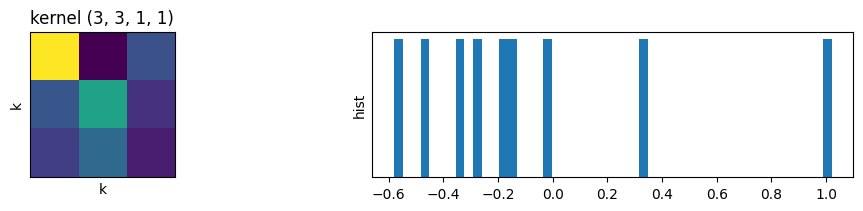

In [ ]:
# accumulated effect: conv layers (no padding)
# - vignetting effect
# - looks like checkerboarding effects
input = tf.keras.Input(shape=(15, 15, 1))
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(input)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
# just plot a few layers
plot_image_batch(layer_gradients[2])
plot_image_batch(layer_gradients[5])
plot_kernel(parameter_gradients[0])
plot_kernel(parameter_gradients[6])
plot_kernel(parameter_gradients[12])

Input:  (32, 15, 15, 1)
Output: (32, 15, 15, 1)
Loss:   1.9135246276855469 <- 1.2536681914809833e-08..35.02313232421875
Parameter gradients (14): [TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1])]
Input gradients: (32, 15, 15, 1)
Layer gradients (7): [TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1])]
Layer outputs (7): [TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1]), TensorShape([32, 15, 15, 1])]


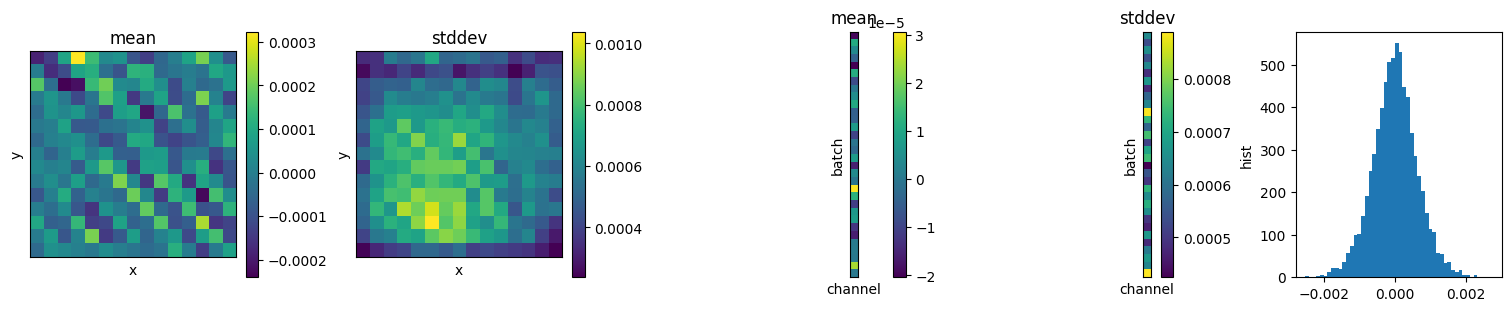

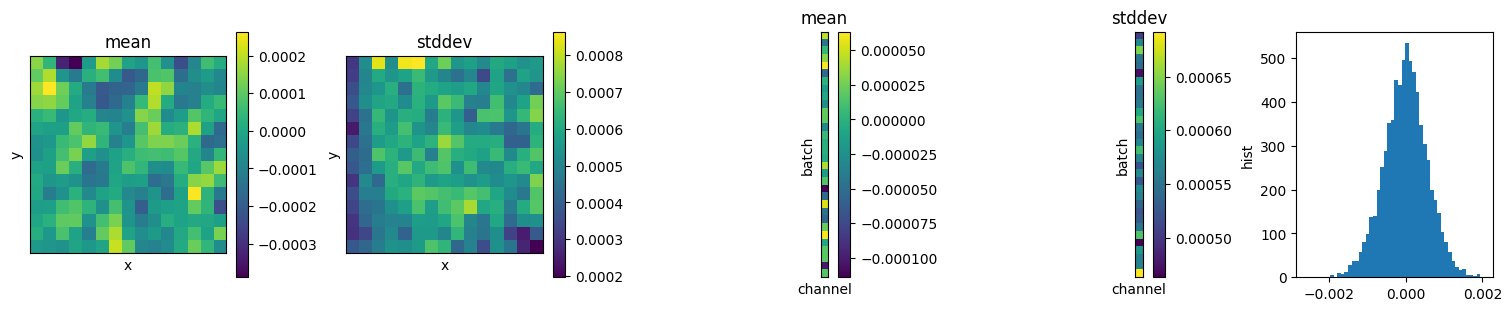

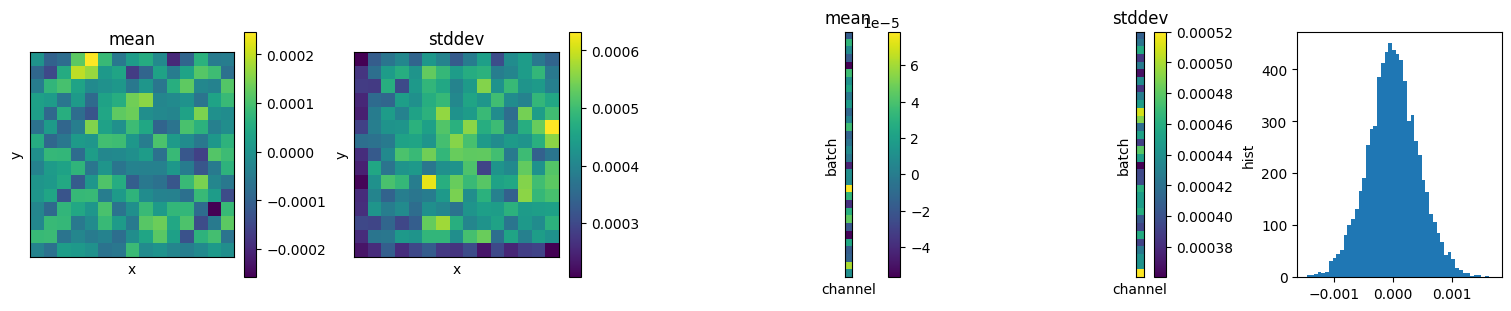

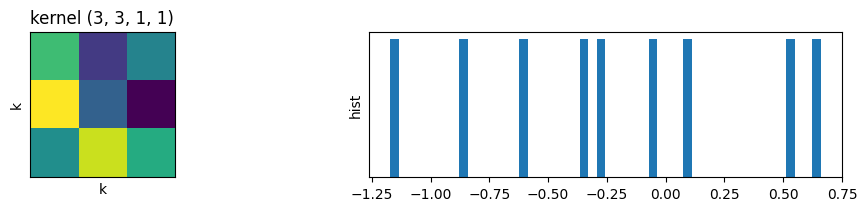

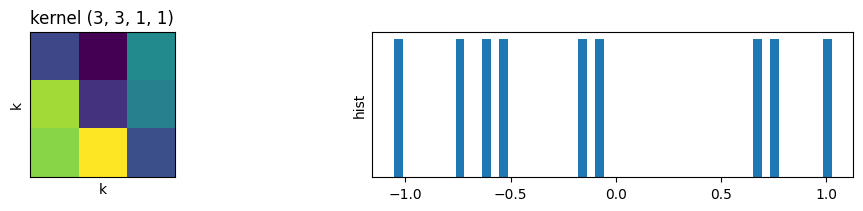

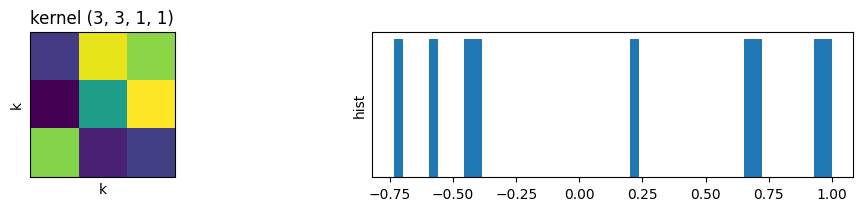

In [ ]:
# accumulated effect: conv layers (padding)
# - vignetting effect is less
# - obvious checkerboarding as well
input = tf.keras.Input(shape=(15, 15, 1))
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(input)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
# just plot a few layers
plot_image_batch(input_gradients)
plot_image_batch(layer_gradients[2])
plot_image_batch(layer_gradients[5])
plot_kernel(parameter_gradients[0])
plot_kernel(parameter_gradients[6])
plot_kernel(parameter_gradients[12])

Input:  (32, 149, 149, 1)
Output: (32, 74, 74, 1)
Loss:   2.5509982109069824 <- 1.1542766742422828e-11..42.84244918823242
Parameter gradients (0): []
Input gradients: (32, 149, 149, 1)
Layer gradients (1): [TensorShape([32, 74, 74, 1])]
Layer outputs (1): [TensorShape([32, 74, 74, 1])]

Input:  (32, 149, 149, 1)
Output: (32, 73, 73, 32)
Loss:   1.092918038368225 <- 0.2712922990322113..2.777456760406494
Parameter gradients (2): [TensorShape([3, 3, 1, 32]), TensorShape([32])]
Input gradients: (32, 149, 149, 1)
Layer gradients (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 73, 73, 32])]
Layer outputs (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 73, 73, 32])]


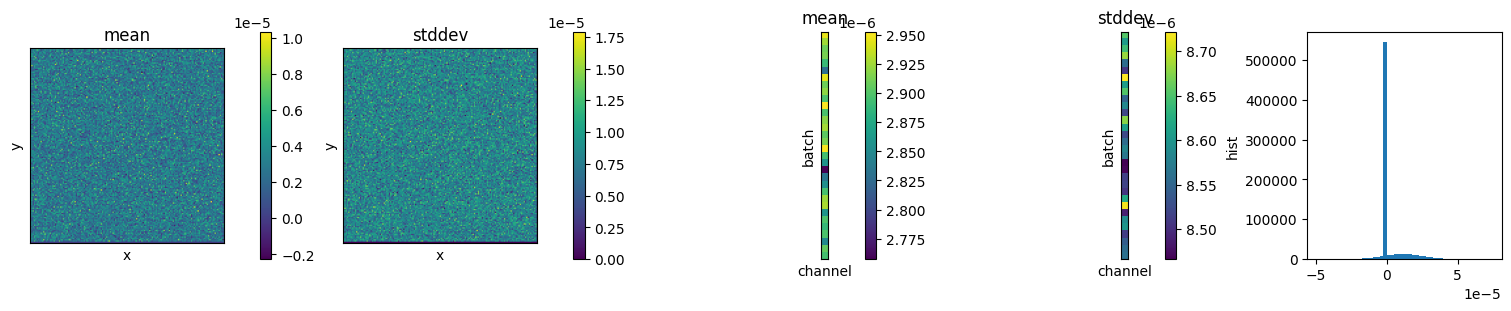

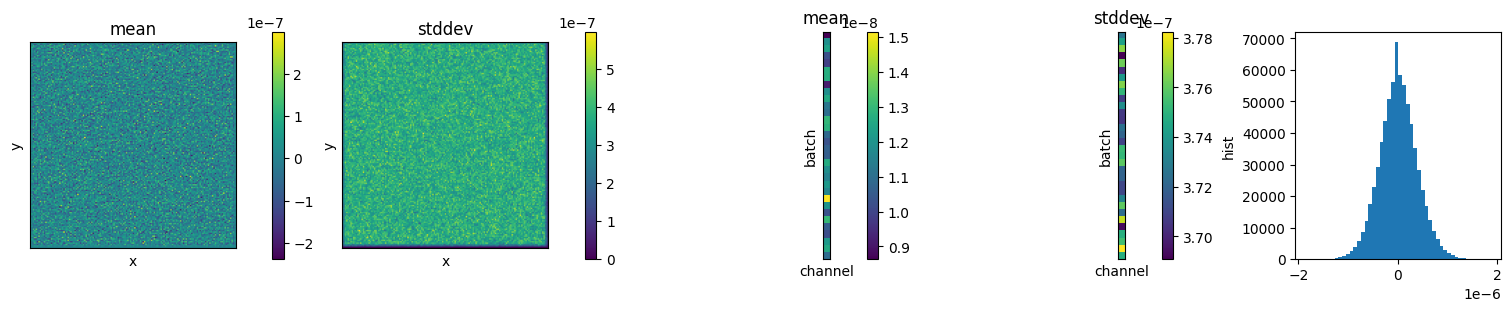

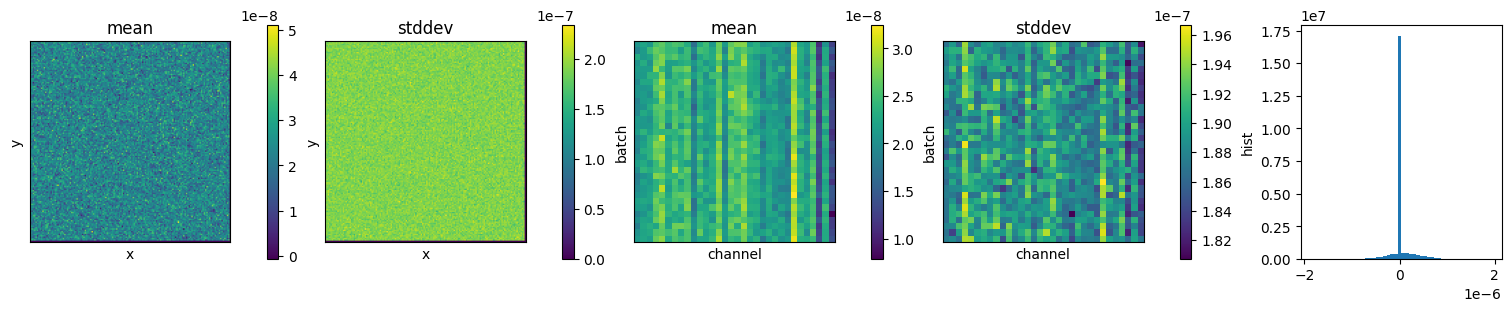

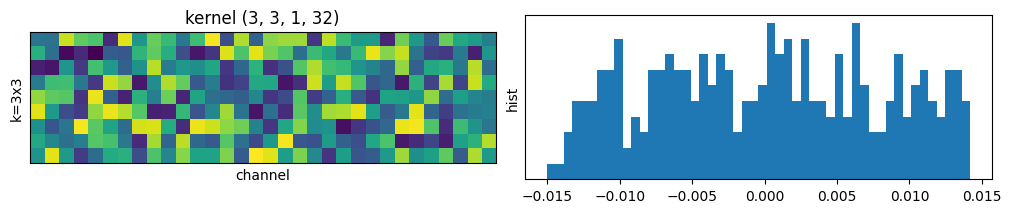

In [ ]:
# simple example: maxpool only
input = tf.keras.Input(shape=(149, 149, 1))
x = layers.MaxPool2D()(input)
parameter_gradients, input_gradients, _, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)

# simple example: conv+maxpool
print()
input = tf.keras.Input(shape=(149, 149, 1))
x = layers.Conv2D(32, kernel_size=(3, 3))(input)
x = layers.MaxPool2D()(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_image_batch(layer_gradients[0])
plot_kernel(parameter_gradients[0])

Input:  (32, 16, 16, 1)
Output: (32, 1, 1, 1)
Loss:   10.51901626586914 <- 0.3372468650341034..26.425132751464844
Parameter gradients (0): []
Input gradients: (32, 16, 16, 1)
Layer gradients (4): [TensorShape([32, 8, 8, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 1, 1, 1])]
Layer outputs (4): [TensorShape([32, 8, 8, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 1, 1, 1])]


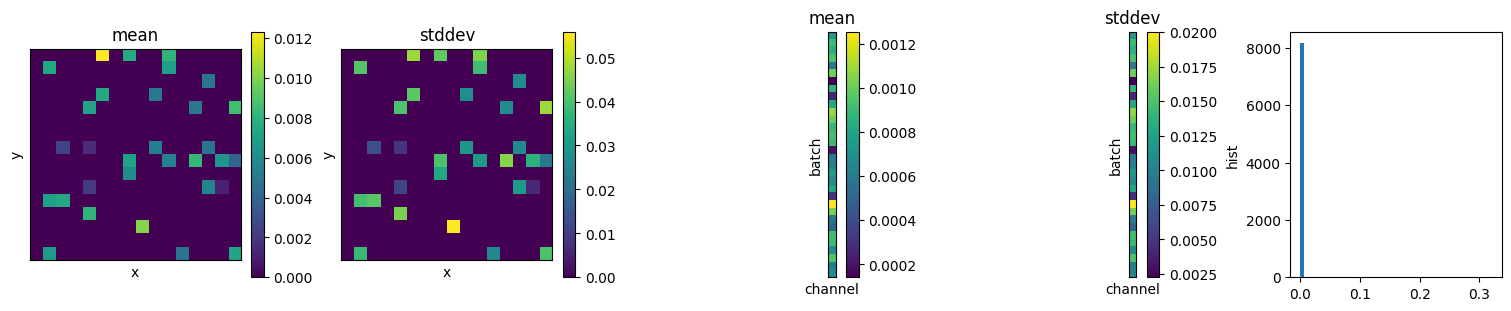

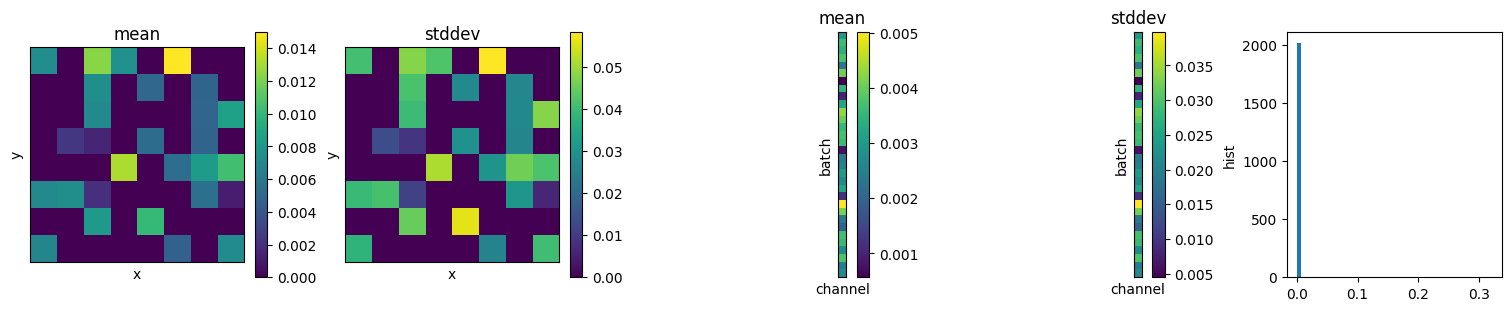

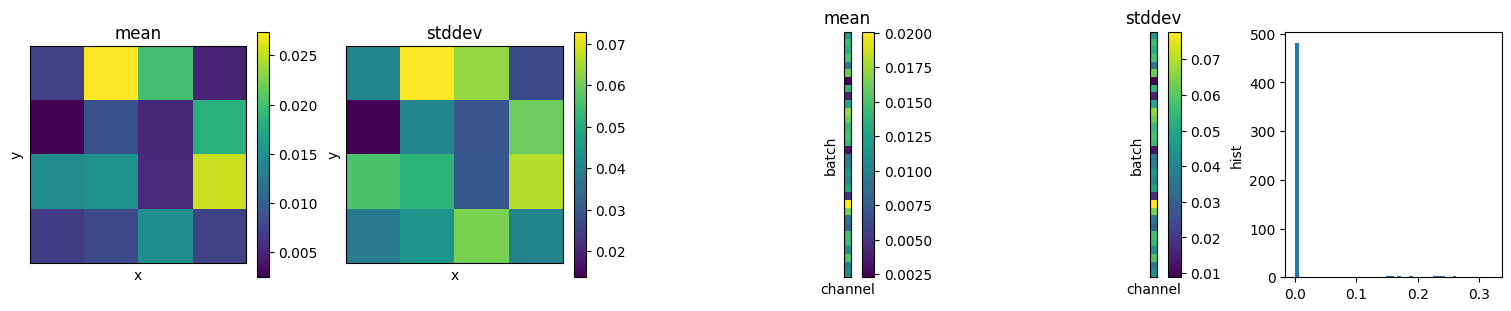

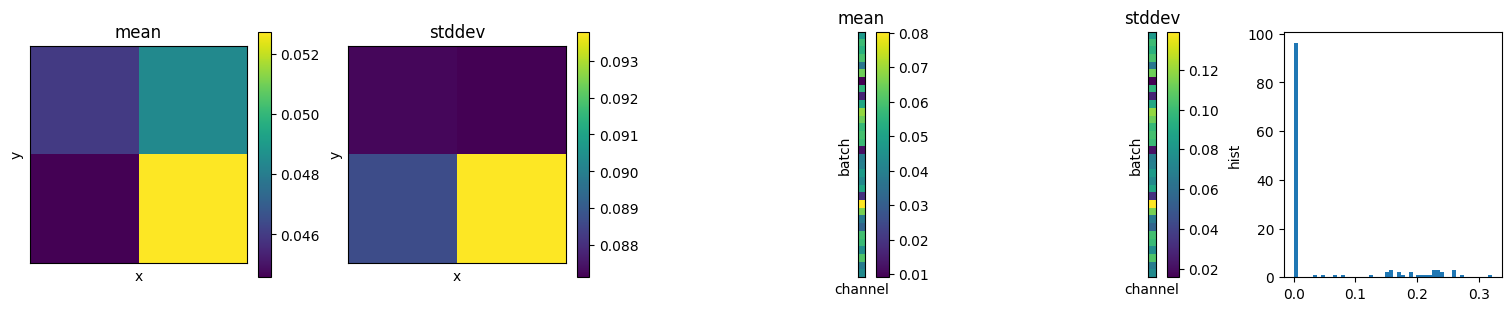

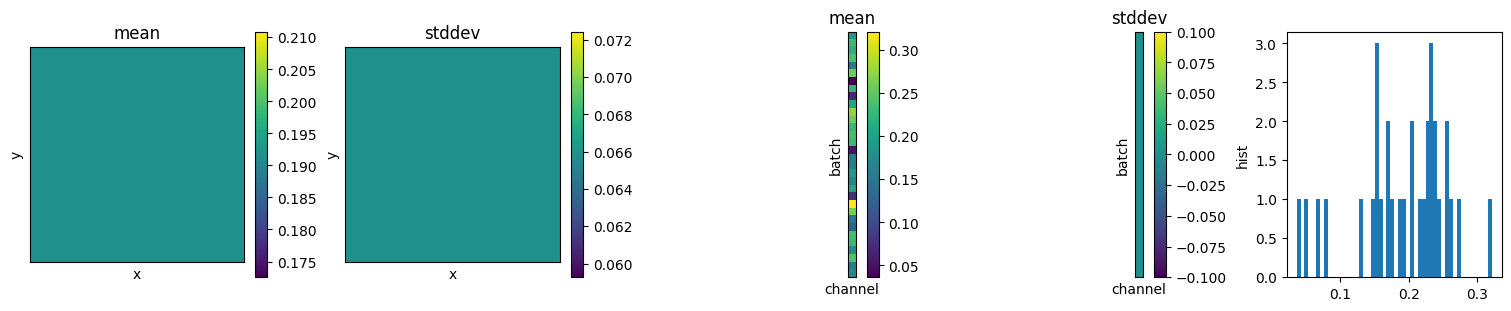

In [ ]:
# accumulated effect: maxpool on smaller layers
input = tf.keras.Input(shape=(16, 16, 1))
x = layers.MaxPool2D()(input)
x = layers.MaxPool2D()(x)
x = layers.MaxPool2D()(x)
x = layers.MaxPool2D()(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
for g in layer_gradients:
  plot_image_batch(g)

Input:  (32, 46, 46, 1)
Output: (32, 1, 1, 1)
Loss:   1.5871663093566895 <- 0.0016636750660836697..7.96633243560791
Parameter gradients (8): [TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1])]
Input gradients: (32, 46, 46, 1)
Layer gradients (8): [TensorShape([32, 44, 44, 1]), TensorShape([32, 22, 22, 1]), TensorShape([32, 20, 20, 1]), TensorShape([32, 10, 10, 1]), TensorShape([32, 8, 8, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 1, 1, 1])]
Layer outputs (8): [TensorShape([32, 44, 44, 1]), TensorShape([32, 22, 22, 1]), TensorShape([32, 20, 20, 1]), TensorShape([32, 10, 10, 1]), TensorShape([32, 8, 8, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 1, 1, 1])]


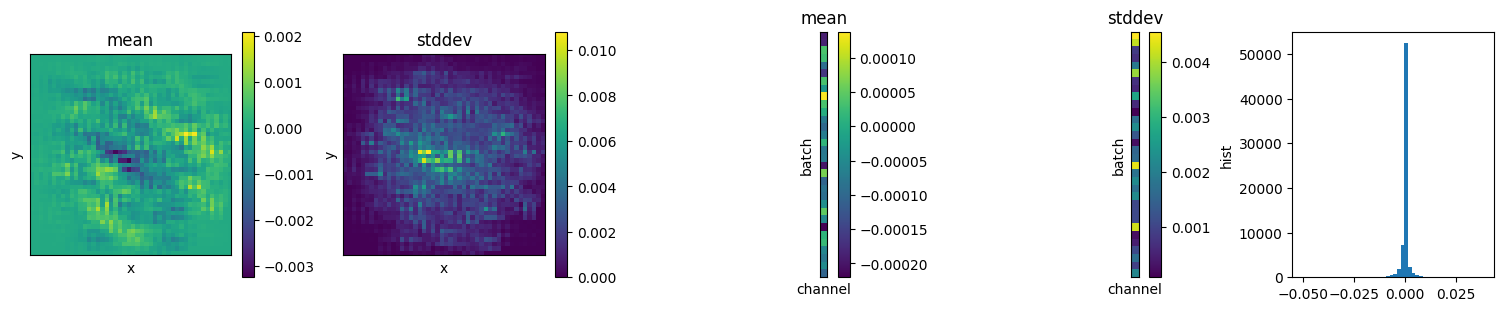

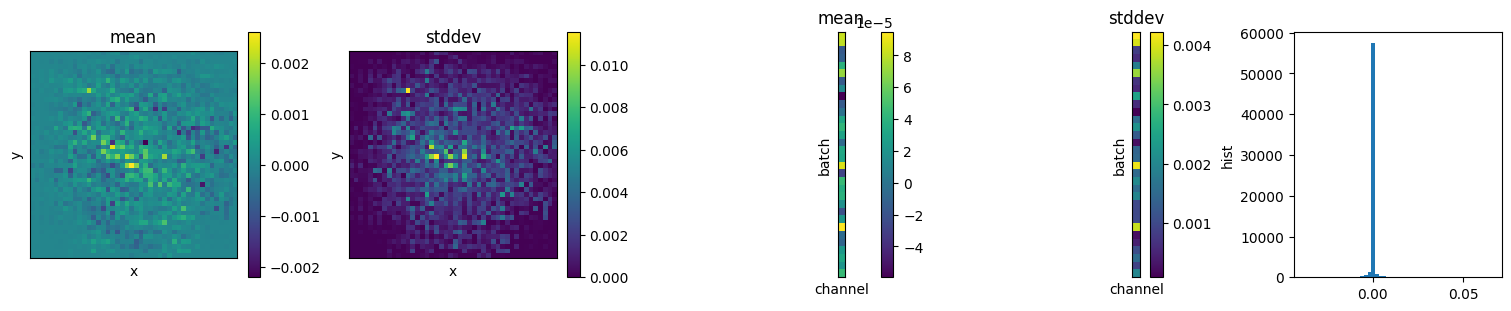

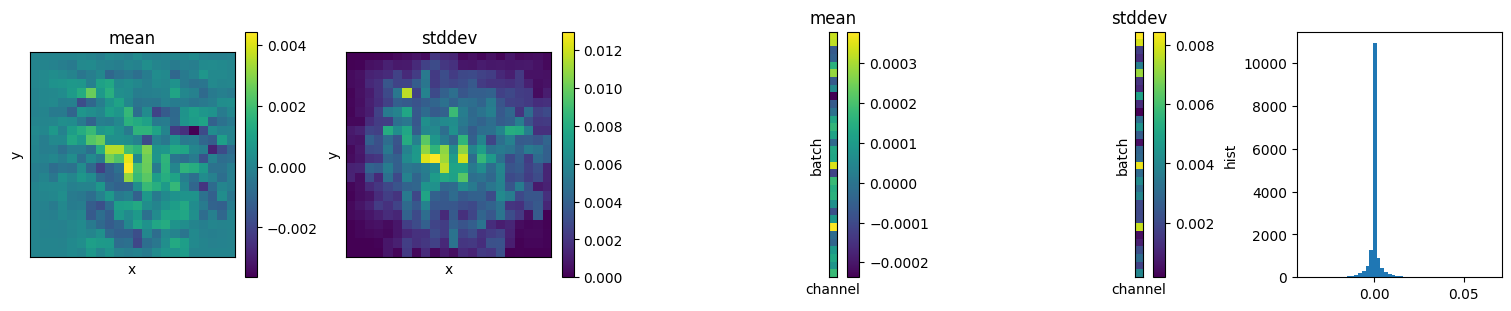

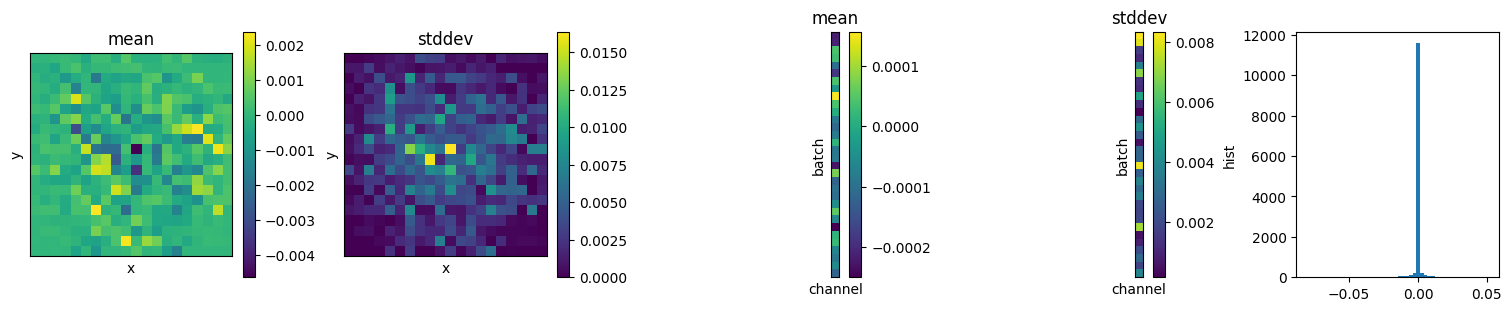

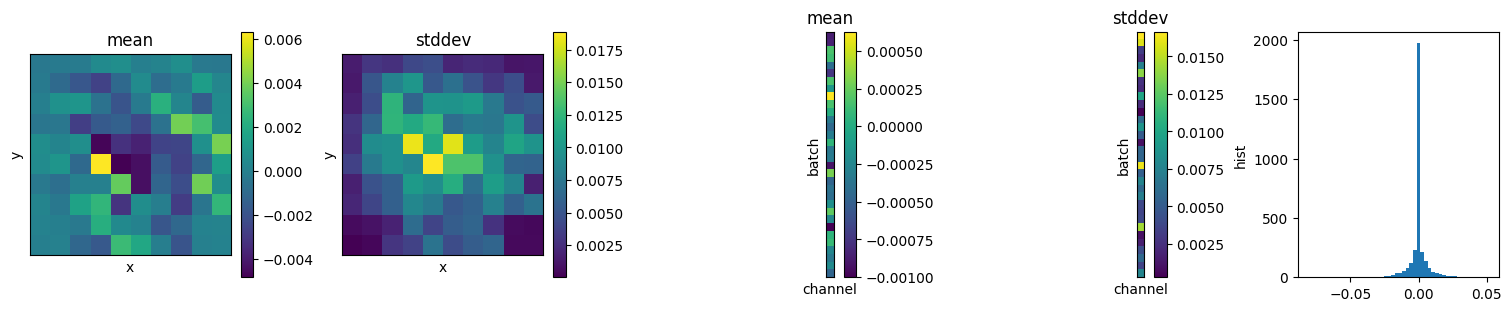

In [ ]:
# accumulated effect: maxpool on smaller layers with conv
input = tf.keras.Input(shape=(46, 46, 1))
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='valid')(x)
x = layers.MaxPool2D()(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
# just plot earliest few layers
plot_image_batch(layer_gradients[0])
plot_image_batch(layer_gradients[1])
plot_image_batch(layer_gradients[2])
plot_image_batch(layer_gradients[3])

Input:  (32, 64, 64, 1)
Output: (32, 1, 1, 1)
Loss:   1.7256340980529785 <- 0.00043013656977564096..7.332058906555176
Parameter gradients (12): [TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1]), TensorShape([3, 3, 1, 1]), TensorShape([1])]
Input gradients: (32, 64, 64, 1)
Layer gradients (12): [TensorShape([32, 64, 64, 1]), TensorShape([32, 32, 32, 1]), TensorShape([32, 32, 32, 1]), TensorShape([32, 16, 16, 1]), TensorShape([32, 16, 16, 1]), TensorShape([32, 8, 8, 1]), TensorShape([32, 8, 8, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 4, 4, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 2, 2, 1]), TensorShape([32, 1, 1, 1])]
Layer outputs (12): [TensorShape([32, 64, 64, 1]), TensorShape([32, 32, 32, 1]), TensorShape([32, 32, 32, 1]), TensorShape([32, 16, 16, 1]), TensorShape([32, 16, 16, 1]), TensorShape(

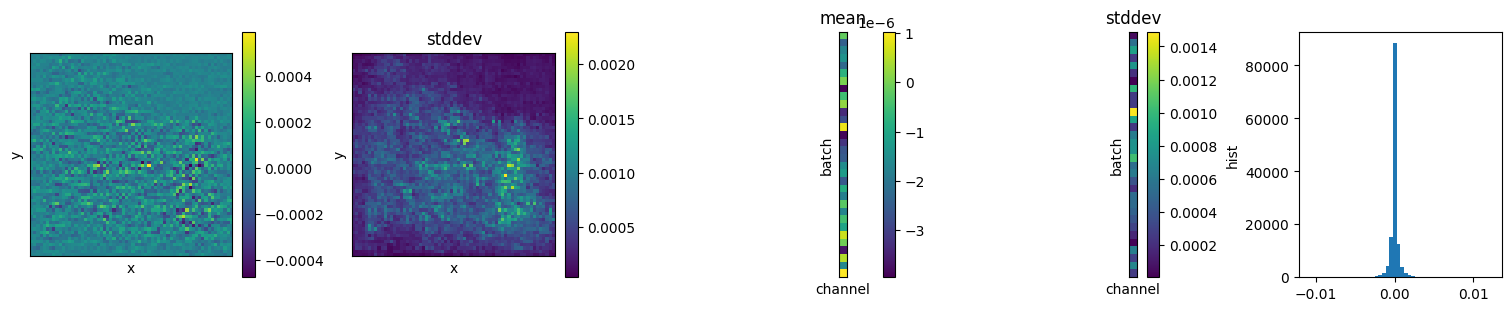

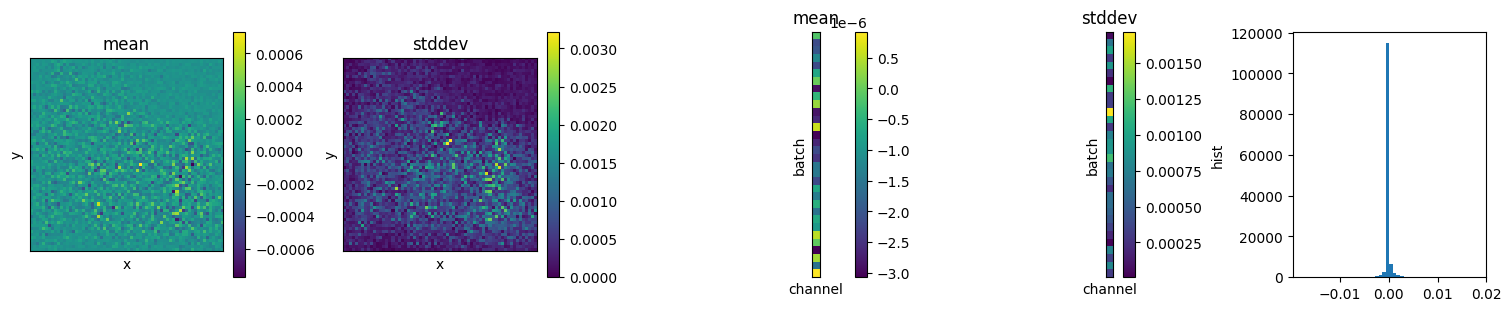

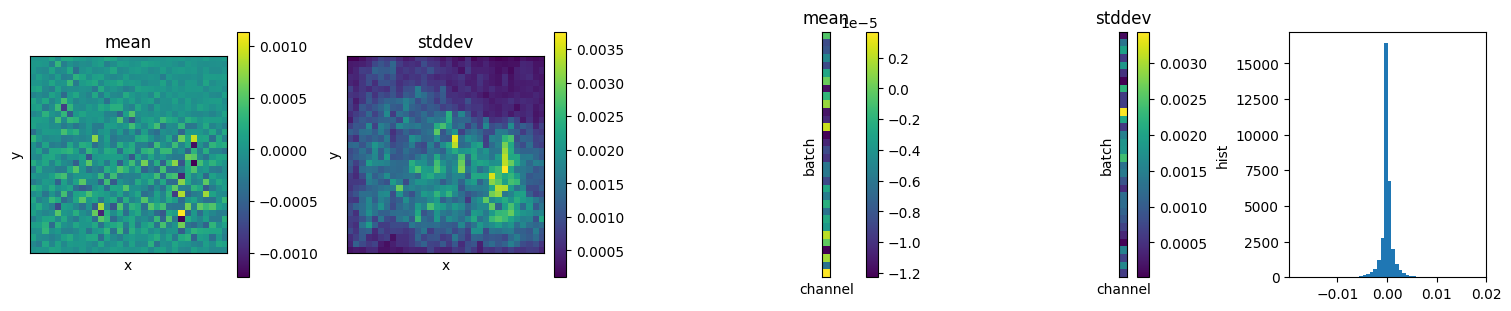

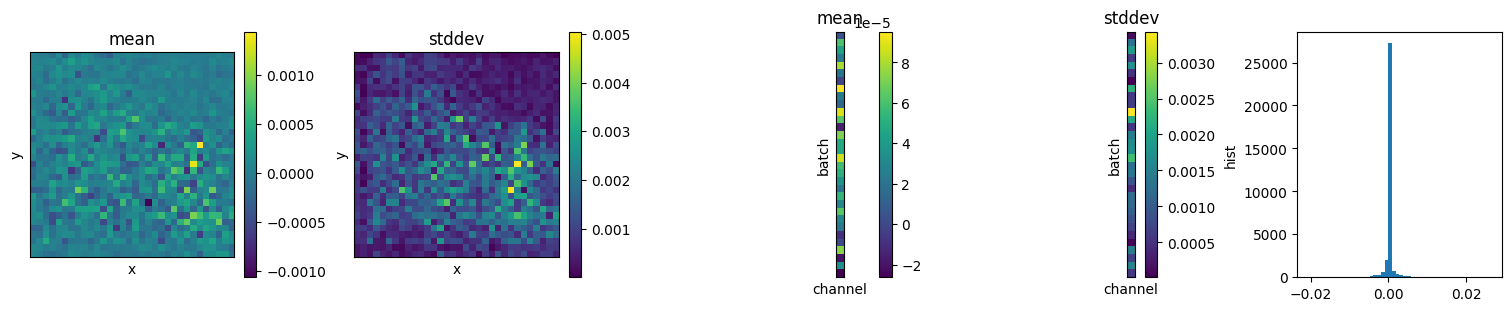

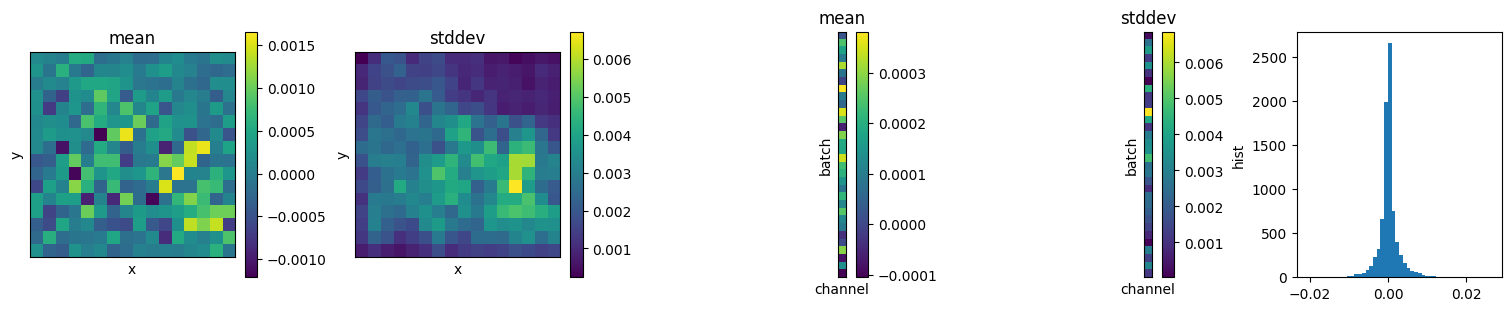

In [ ]:
# accumulated effect: maxpool on smaller layers with conv
input = tf.keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(1, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D()(x)
parameter_gradients, input_gradients, layer_gradients, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
# just plot earliest few layers
plot_image_batch(layer_gradients[0])
plot_image_batch(layer_gradients[1])
plot_image_batch(layer_gradients[2])
plot_image_batch(layer_gradients[3])

### Checkerboarding effects

Input:  (32, 32, 32, 1)
Output: (32, 16, 16, 2)
Loss:   1.2461034059524536 <- 1.3052453141426668e-05..12.878952026367188
Parameter gradients (8): [TensorShape([3, 3, 1, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2])]
Input gradients: (32, 32, 32, 1)
Layer gradients (5): [TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 16, 16, 2])]
Layer outputs (5): [TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 16, 16, 2])]


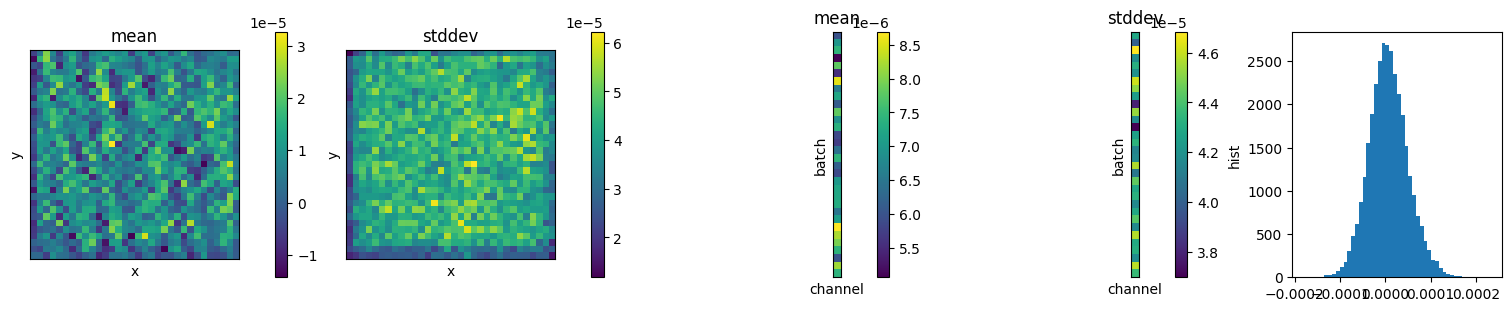

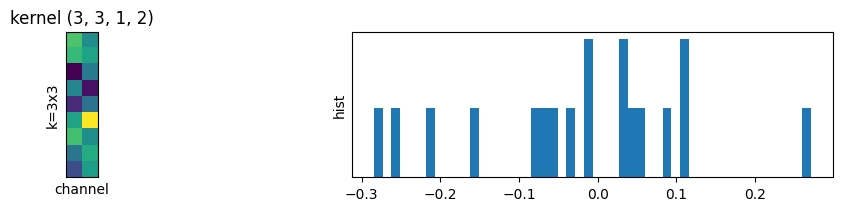

In [ ]:
# Looking again at checkerboard pattern from convolutions
# - see: Zhang, R. (2019). Making Convolutional Networks Shift-Invariant Again. ICML. https://doi.org/10.48550/arXiv.1904.11486
# - see: Odena, et al. (2016). Deconvolution and Checkerboard Artifacts. Distill. http://doi.org/10.23915/distill.00003
input = tf.keras.Input(shape=(32, 32, 1))
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
x = layers.MaxPool2D()(features)   # <--- not so bad if this is omitted
parameter_gradients, input_gradients, _, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

Input:  (32, 32, 32, 1)
Output: (32, 16, 16, 2)
Loss:   1.090209722518921 <- 0.00014757410099264234..10.341275215148926
Parameter gradients (10): [TensorShape([3, 3, 1, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2]), TensorShape([3, 3, 2, 2]), TensorShape([2])]
Input gradients: (32, 32, 32, 1)
Layer gradients (7): [TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), None, TensorShape([32, 16, 16, 2])]
Layer outputs (7): [TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 32, 32, 2]), TensorShape([32, 16, 16, 2])]


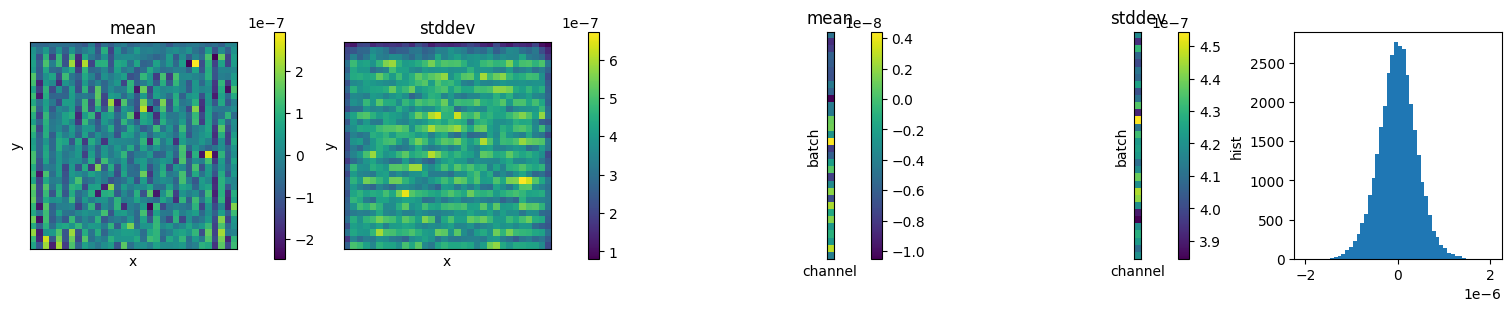

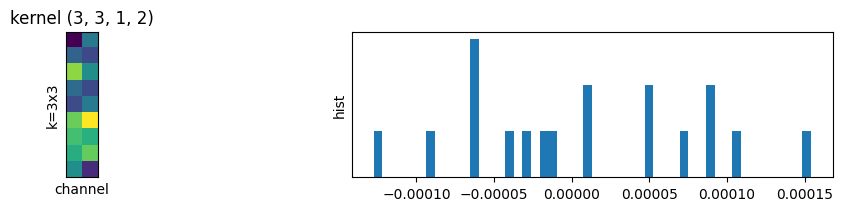

In [ ]:
# "Expected Coordinate" via soft-selection
# - checkerboarding is significant at around 32x32 or larger, it's present at lower resolutions too but harder to visually spot the pattern
input = tf.keras.Input(shape=(32, 32, 1))
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
coords = CoordGrid2D()(input)
x = AttentionPool2D()(features, coords)
parameter_gradients, input_gradients, _, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

### Looking at architectural types

Input:  (32, 149, 149, 1)
Output: (32, 32)
Loss:   2.0032010078430176 <- 1.1866552829742432..2.8747408390045166
Parameter gradients (2): [TensorShape([3, 3, 1, 32]), TensorShape([32])]
Input gradients: (32, 149, 149, 1)
Layer gradients (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 32])]
Layer outputs (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 32])]


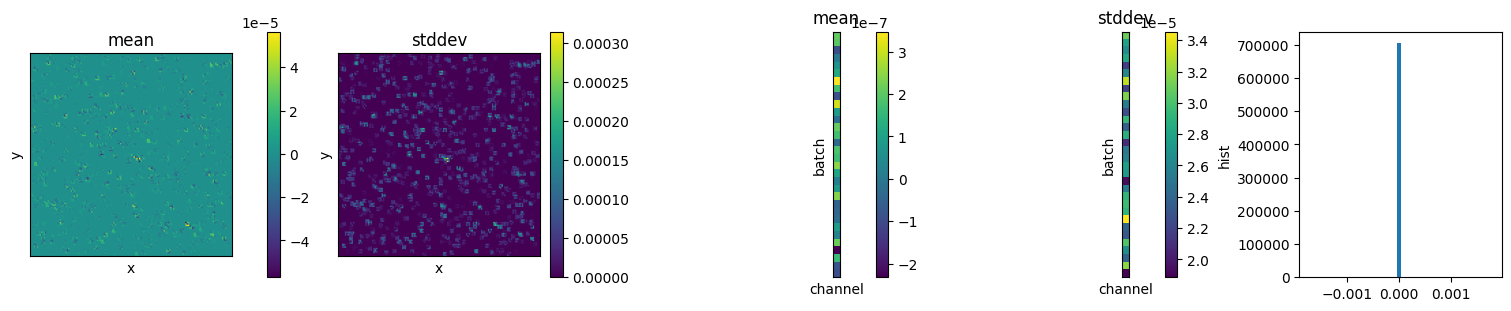

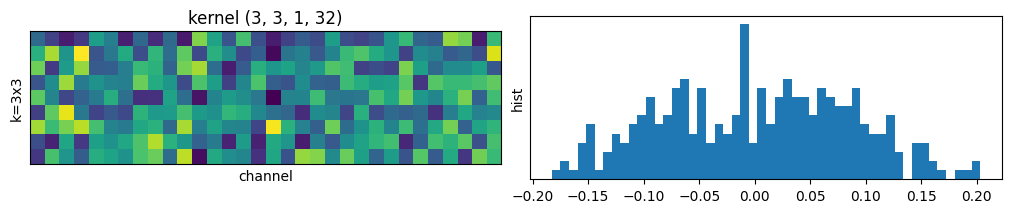

Input:  (32, 149, 149, 1)
Output: (32, 32)
Loss:   0.9247902631759644 <- 0.4296139180660248..1.7679312229156494
Parameter gradients (2): [TensorShape([3, 3, 1, 32]), TensorShape([32])]
Input gradients: (32, 149, 149, 1)
Layer gradients (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 32])]
Layer outputs (2): [TensorShape([32, 147, 147, 32]), TensorShape([32, 32])]


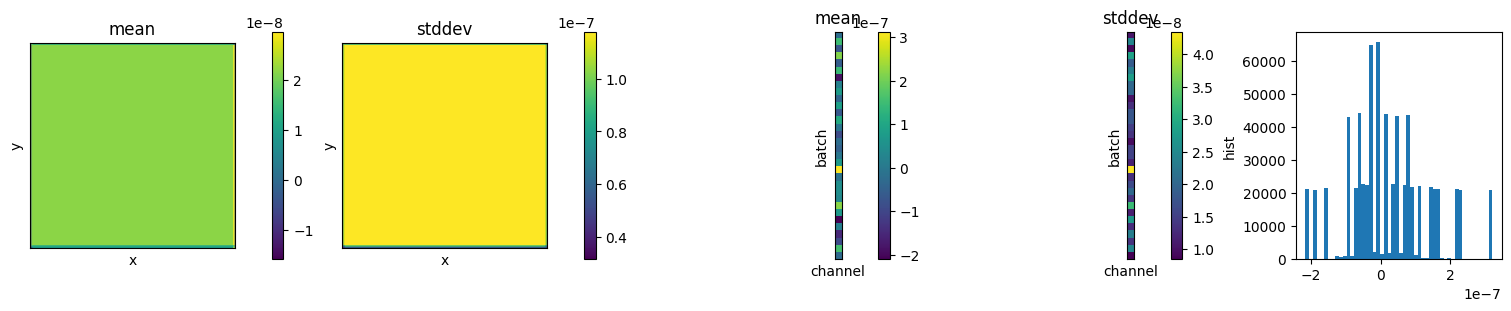

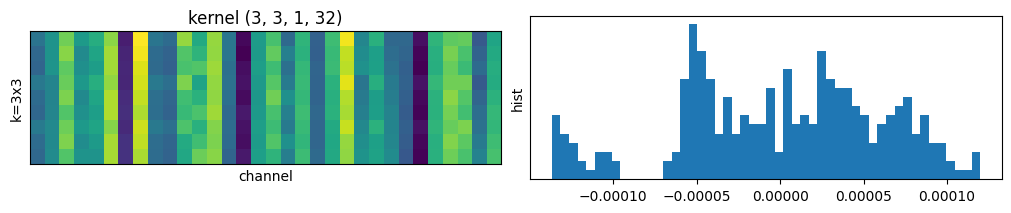

In [ ]:
# Global pooling - GlobalMaxPool
input = tf.keras.Input(shape=(149, 149, 1))
x = layers.Conv2D(32, kernel_size=(3, 3))(input)
x = layers.GlobalMaxPool2D()(x)
parameter_gradients, input_gradients, _ , _= gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

# Global pooling - GlobalAvePool
input = tf.keras.Input(shape=(149, 149, 1))
x = layers.Conv2D(32, kernel_size=(3, 3))(input)
x = layers.GlobalAveragePooling2D()(x)
parameter_gradients, input_gradients, _, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

Input:  (32, 149, 149, 1)
Output: (32, 74, 74, 2)
Loss:   1.0812466144561768 <- 8.227489161072299e-06..12.859943389892578
Parameter gradients (2): [TensorShape([3, 3, 1, 32]), TensorShape([32])]
Input gradients: (32, 149, 149, 1)
Layer gradients (4): [TensorShape([32, 149, 149, 32]), None, TensorShape([32, 149, 149, 34]), TensorShape([32, 74, 74, 34])]
Layer outputs (4): [TensorShape([32, 149, 149, 32]), TensorShape([32, 149, 149, 2]), TensorShape([32, 149, 149, 34]), TensorShape([32, 74, 74, 34])]


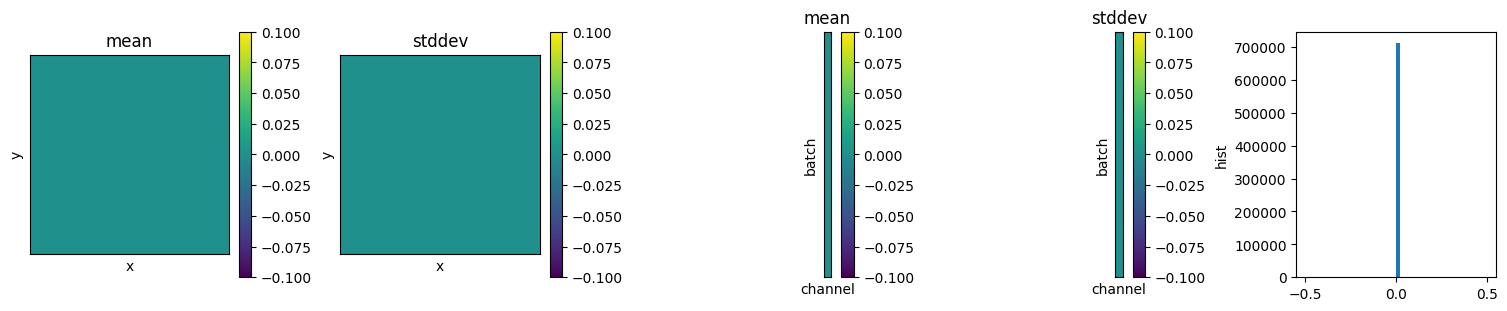

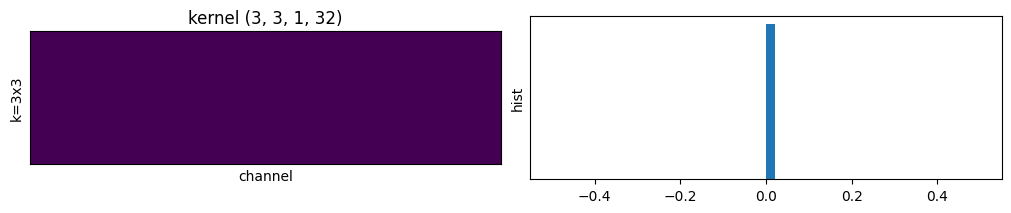

In [ ]:
# Problem case: PositionwiseMaxPool with dropped semantic feature
input = tf.keras.Input(shape=(149, 149, 1))
coords = CoordGrid2D()(input)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same')(input)
x = layers.Concatenate()([x, coords])
x = PositionwiseMaxPool2D(pool_size=(2,2), channel_weights=[1]*32 + [0, 0])(x)
x = x[..., -2:]
parameter_gradients, input_gradients, _, _ = gradients_for(x, inputs=input)
plot_image_batch(input_gradients)
plot_kernel(parameter_gradients[0])

Input:  (32, 4, 4, 1)
Output: (32, 2, 2, 2)
Loss:   1.2601300477981567 <- 0.0005385552067309618..5.445145606994629
Parameter gradients (2): [TensorShape([3, 3, 1, 2]), TensorShape([2])]
Input gradients: (32, 4, 4, 1)
Layer gradients (3): [TensorShape([32, 4, 4, 2]), None, TensorShape([32, 2, 2, 2])]
Layer outputs (3): [TensorShape([32, 4, 4, 2]), TensorShape([32, 4, 4, 2]), TensorShape([32, 2, 2, 2])]


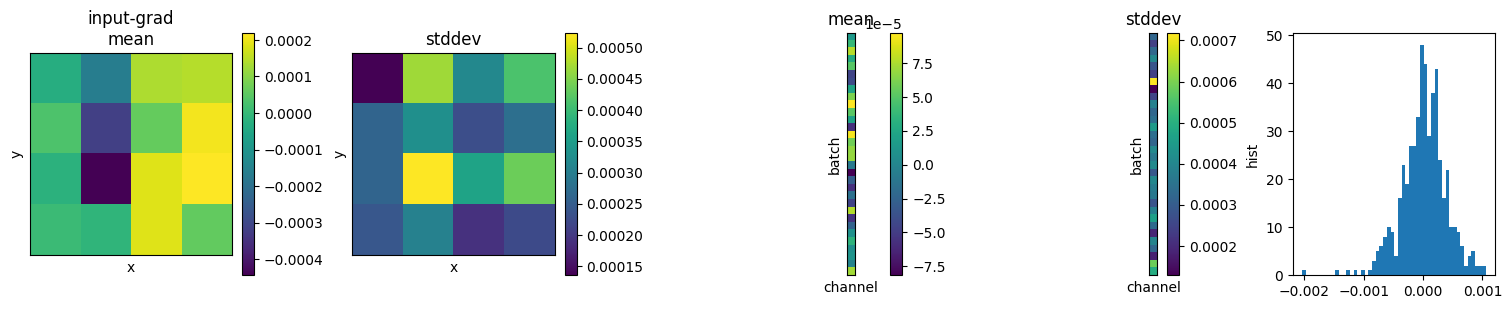

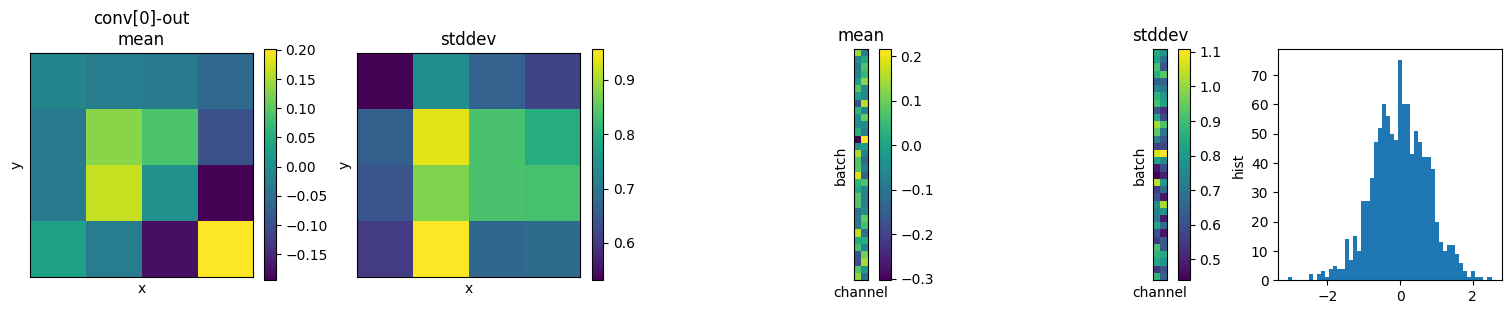

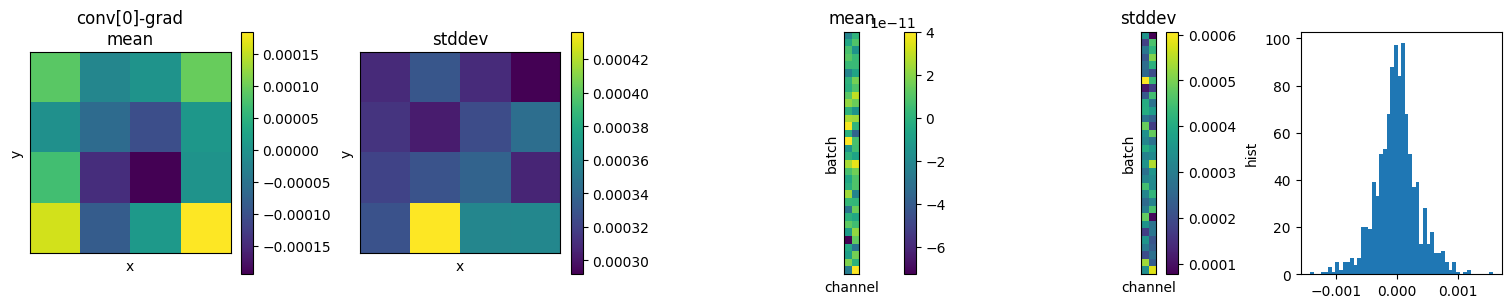

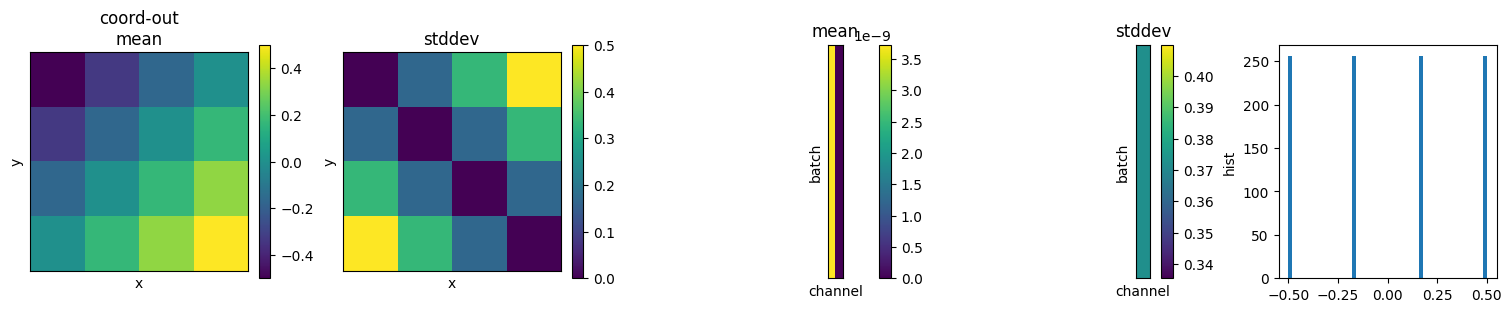

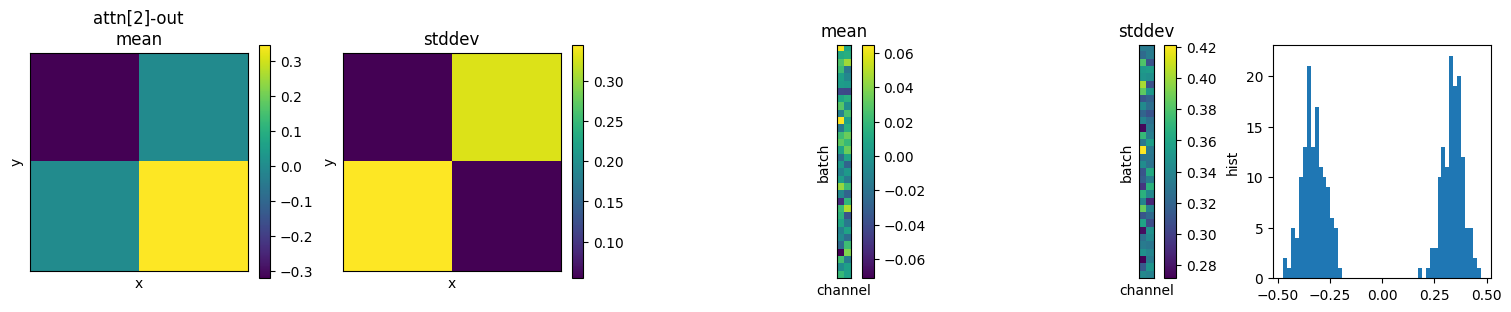

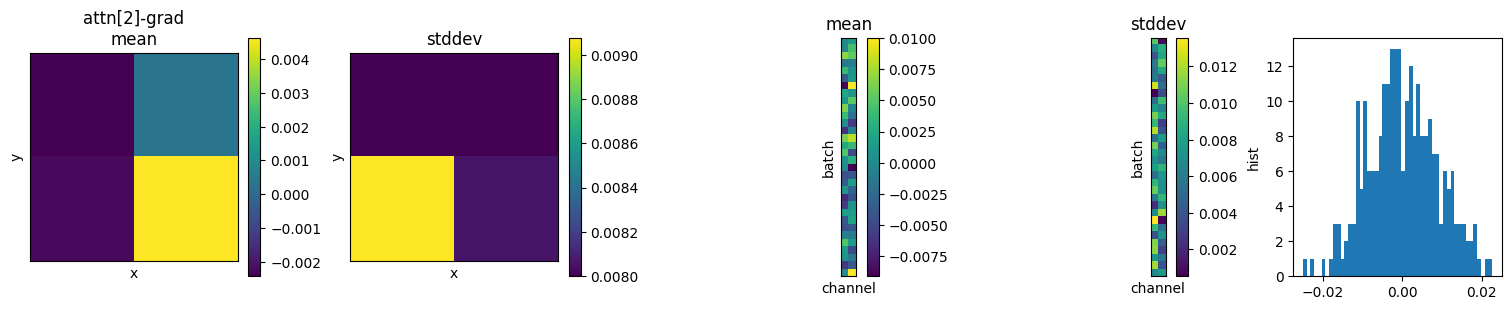

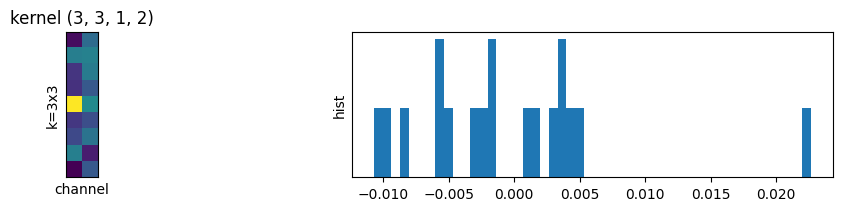

In [ ]:
# "Expected Coordinate" via soft-selection
# - note that checkerboarding is significant at around 32x32 or larger
input = tf.keras.Input(shape=(4, 4, 1))
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
coords = CoordGrid2D()(input)  # -> layer_gradients[0] = None
x = AttentionPool2D()(features, coords)
parameter_gradients, input_gradients, layer_gradients, layer_outputs = gradients_for(x, inputs=input)
plot_image_batch(input_gradients, "input-grad")
plot_image_batch(layer_outputs[0], "conv[0]-out")
plot_image_batch(layer_gradients[0], "conv[0]-grad")
plot_image_batch(layer_outputs[1], "coord-out")
plot_image_batch(layer_outputs[2], "attn[2]-out")
plot_image_batch(layer_gradients[2], "attn[2]-grad")
plot_kernel(parameter_gradients[0])

Input:  (32, 4, 4, 1)
Output: (32, 2, 2, 2)
Loss:   1.0793241262435913 <- 0.015129734762012959..5.4306111335754395
Parameter gradients (2): [TensorShape([3, 3, 1, 2]), TensorShape([2])]
Input gradients: (32, 4, 4, 1)
Layer gradients (4): [TensorShape([32, 4, 4, 2]), TensorShape([32, 4, 4, 2]), None, TensorShape([32, 2, 2, 2])]
Layer outputs (4): [TensorShape([32, 4, 4, 2]), TensorShape([32, 4, 4, 2]), TensorShape([32, 4, 4, 2]), TensorShape([32, 2, 2, 2])]


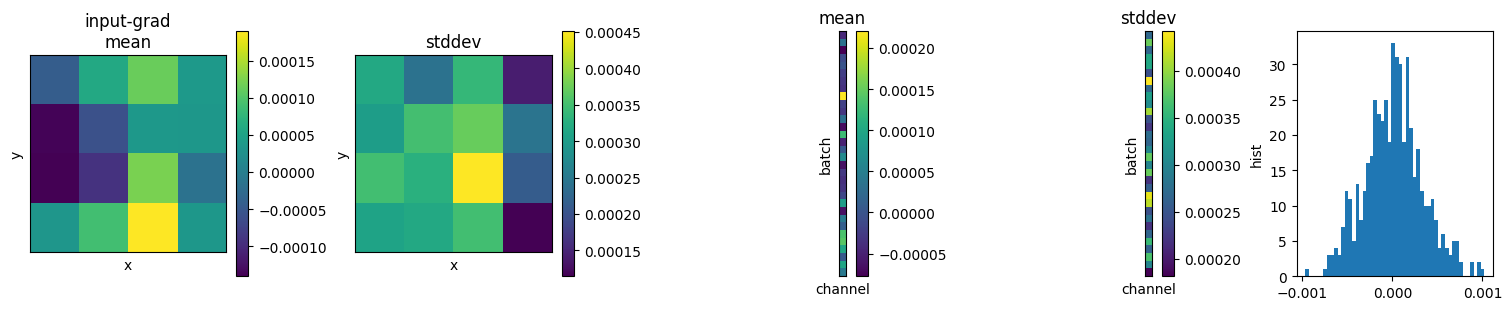

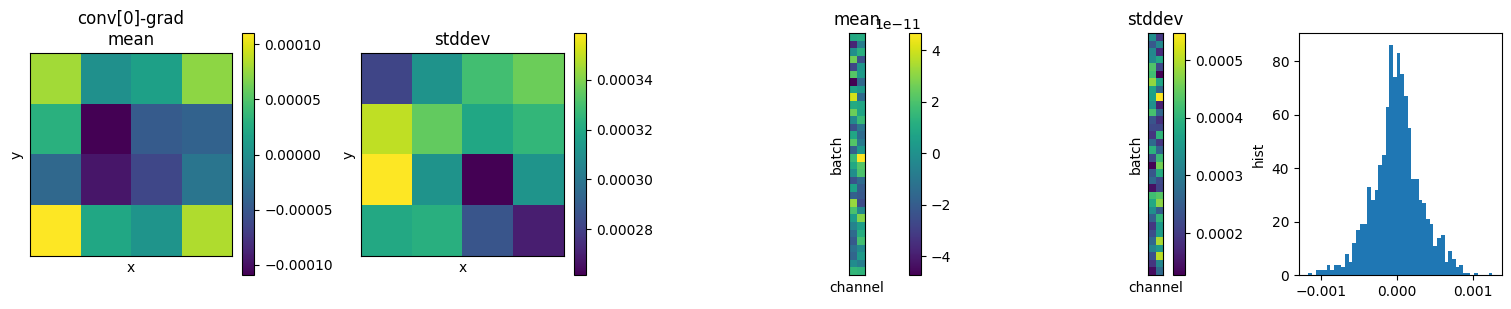

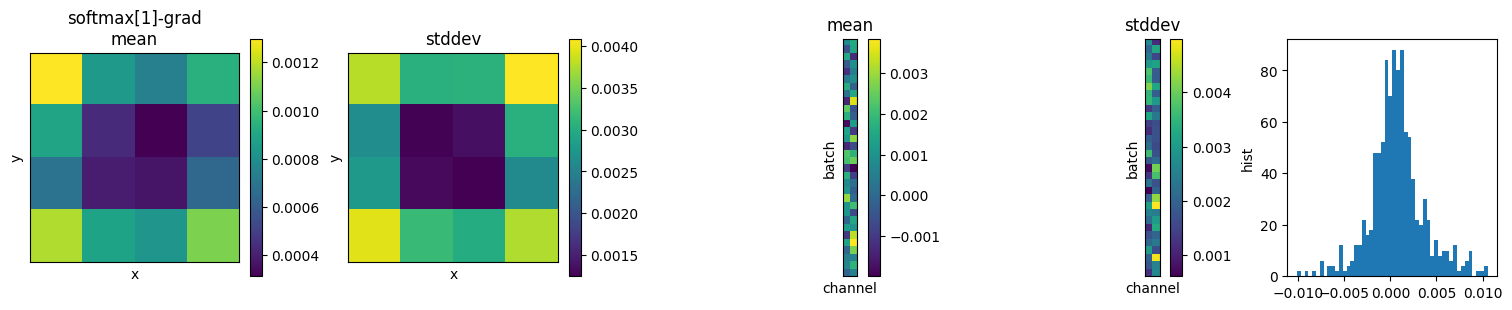

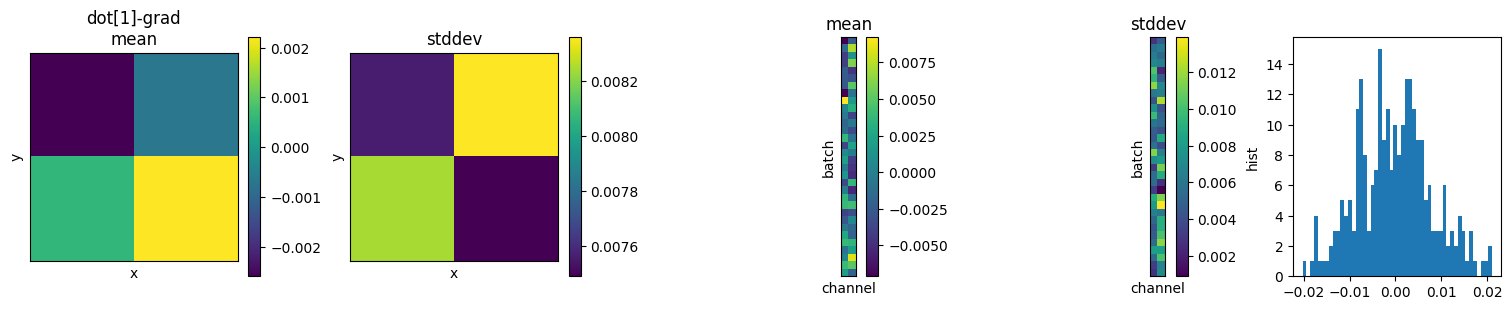

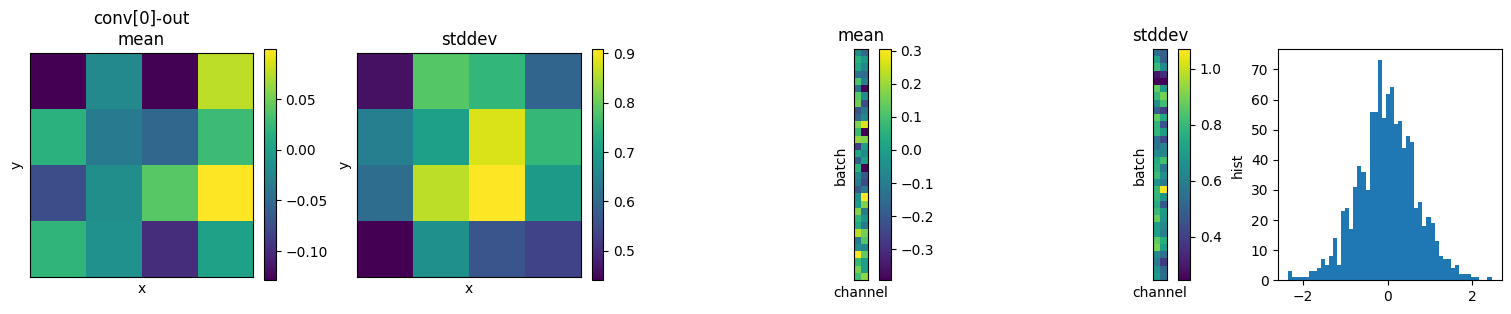

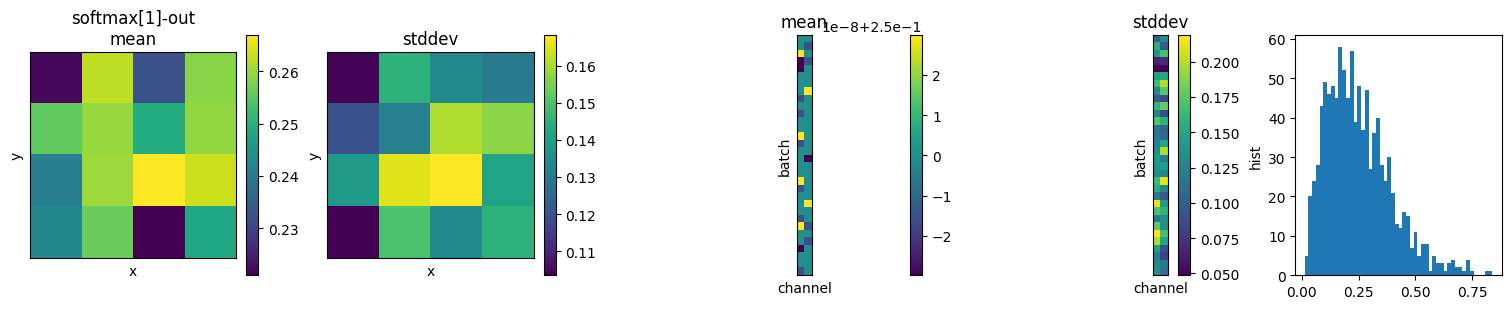

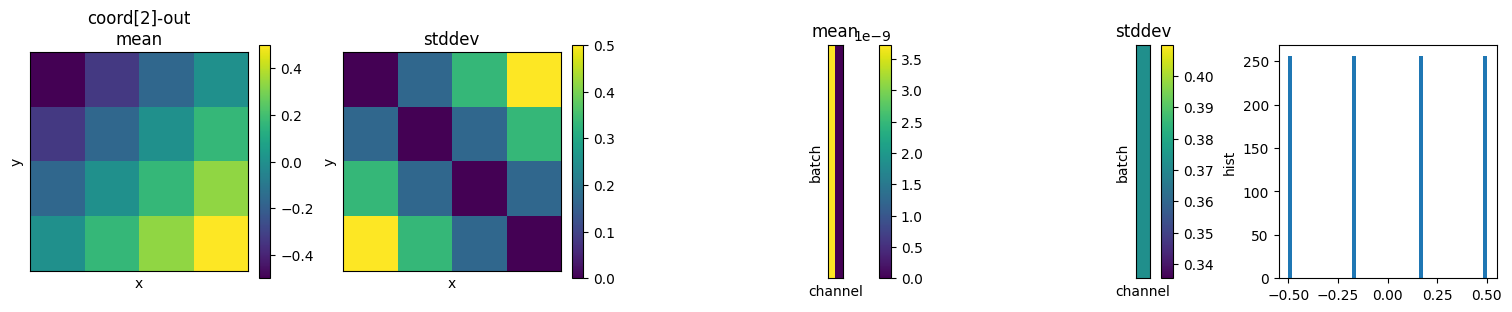

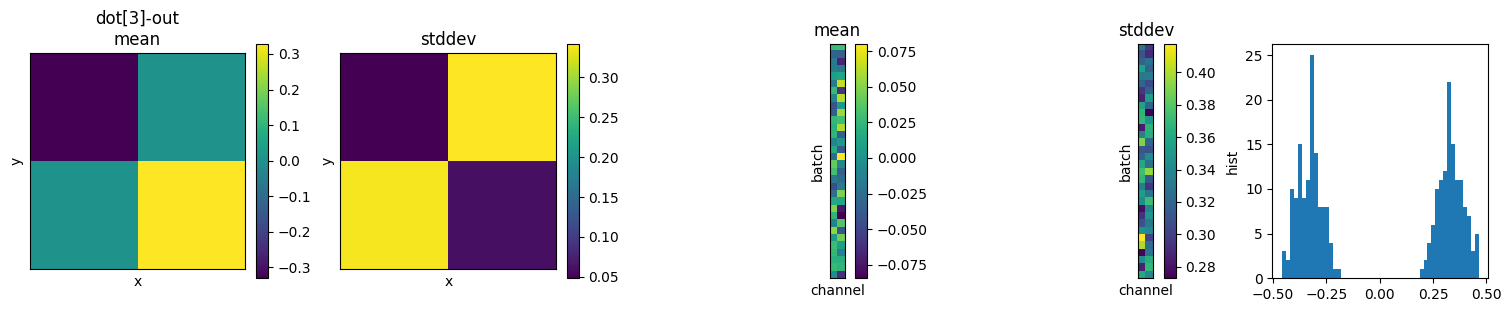

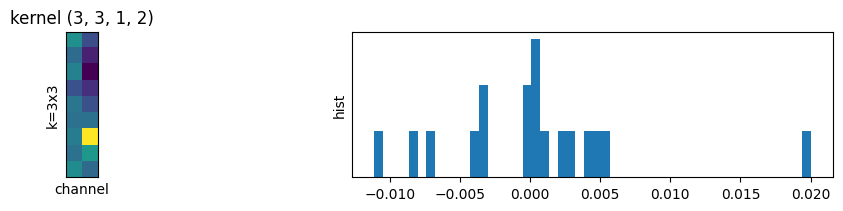

In [ ]:
# "Expected Coordinate" via soft-selection (broken down)
input = tf.keras.Input(shape=(4, 4, 1))
features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
features = StridedSoftmax2D()(features)
coords = CoordGrid2D()(input)  # -> layer_gradients[2] = None
x = DotPool2D()(features, coords)
parameter_gradients, input_gradients, layer_gradients, layer_outputs = gradients_for(x, inputs=input)
plot_image_batch(input_gradients, "input-grad")
plot_image_batch(layer_gradients[0], "conv[0]-grad")
plot_image_batch(layer_gradients[1], "softmax[1]-grad")
plot_image_batch(layer_gradients[3], "dot[1]-grad")
plot_image_batch(layer_outputs[0], "conv[0]-out")
plot_image_batch(layer_outputs[1], "softmax[1]-out")
plot_image_batch(layer_outputs[2], "coord[2]-out")
plot_image_batch(layer_outputs[3], "dot[3]-out")
plot_kernel(parameter_gradients[0])

### Comparing Architecture Efficiency
On very simple minimum-layer networks and very simple datasets.

In [ ]:
def compare_model_efficiency(model, dataset, epochs=1000):
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger()])
  tinstr.plot_train_history(history)

  x, y_true = next(iter(dataset.take(1)))
  y_pred = model(x)
  print(f"input={x.shape}, output={y_pred.shape}")
  print(f"y_true[0]: {y_true[0].numpy().flatten()}")
  print(f"y_pred[0]: {y_pred[0].numpy().flatten()}")
  print(f"error[0]:  {(y_true - y_pred)[0].numpy().flatten()}")

Epoch   100 - 14.04ms/epoch: loss: 0.4856  mae: 0.5500  
Epoch   200 - 10.29ms/epoch: loss: 0.3484  mae: 0.4651  
Epoch   300 - 6.78ms/epoch: loss: 0.2866  mae: 0.4209  
Epoch   400 - 6.11ms/epoch: loss: 0.2495  mae: 0.3923  
Epoch   500 - 6.26ms/epoch: loss: 0.2229  mae: 0.3686  
Epoch   600 - 6.53ms/epoch: loss: 0.2071  mae: 0.3526  
Epoch   700 - 6.50ms/epoch: loss: 0.1985  mae: 0.3451  
Epoch   800 - 6.83ms/epoch: loss: 0.1853  mae: 0.3358  
Epoch   900 - 6.34ms/epoch: loss: 0.1754  mae: 0.3280  
Epoch  1000 - 6.33ms/epoch: loss: 0.1603  mae: 0.3104  
Total training time: 7.6 sec


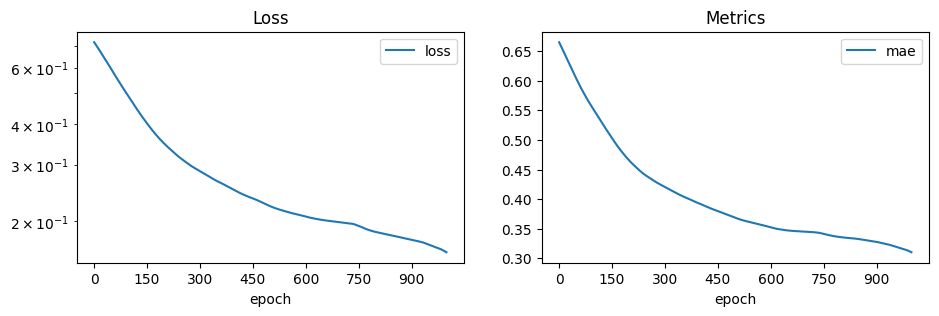

input=(32, 4, 4, 1), output=(32, 2, 2, 2)
y_true[0]: [0.47453076 0.47453076 1.1482275  1.1482275  0.3431165  0.3431165
 1.7083552  1.7083552 ]
y_pred[0]: [0.636413   0.34373334 1.2708653  0.96357155 0.6329834  0.5528396
 1.8246094  1.98924   ]
error[0]:  [-0.16188222  0.13079742 -0.12263787  0.1846559  -0.2898669  -0.20972309
 -0.11625421 -0.28088486]


In [ ]:
# Direct Literal MaxPool
# - After conv, needs to
def get_model():
  input = tf.keras.Input(shape=(4, 4, 1))
  features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
  out = layers.MaxPool2D(pool_size=(2,2))(features)
  return tf.keras.Model(inputs=input, outputs=out)

# dataset:
# - expected output is result of simple maxpool against original input
def get_dataset():
  x = tf.random.normal(shape=(32, 4, 4, 1))
  features = layers.Concatenate()([x, x])  # (32, 4, 4, 2)
  y_true = layers.MaxPool2D(pool_size=(2,2))(features)
  return x, y_true

model = get_model()
dataset = tf.data.Dataset.from_tensor_slices(get_dataset()).batch(32)
compare_model_efficiency(model, dataset)

Epoch   100 - 26.66ms/epoch: loss: 1.4609  mae: 1.0026  
Epoch   200 - 6.96ms/epoch: loss: 1.1687  mae: 0.8995  
Epoch   300 - 6.08ms/epoch: loss: 0.9650  mae: 0.8109  
Epoch   400 - 6.90ms/epoch: loss: 0.8134  mae: 0.7331  
Epoch   500 - 6.68ms/epoch: loss: 0.6943  mae: 0.6635  
Epoch   600 - 6.44ms/epoch: loss: 0.5978  mae: 0.6039  
Epoch   700 - 6.10ms/epoch: loss: 0.5192  mae: 0.5542  
Epoch   800 - 6.49ms/epoch: loss: 0.4552  mae: 0.5153  
Epoch   900 - 6.36ms/epoch: loss: 0.4037  mae: 0.4841  
Epoch  1000 - 7.38ms/epoch: loss: 0.3627  mae: 0.4594  
Total training time: 8.6 sec


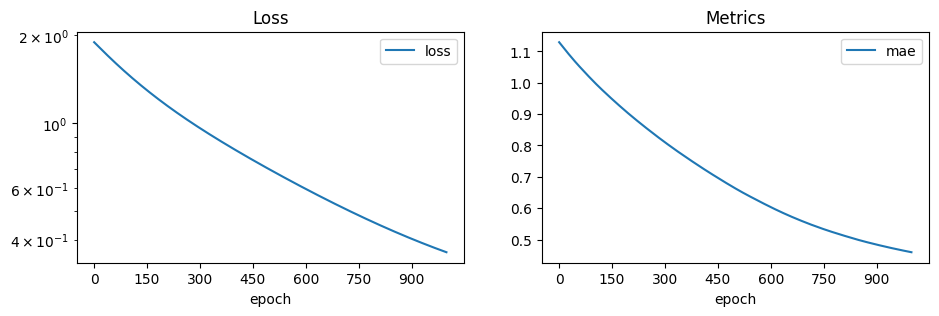

input=(32, 4, 4, 1), output=(32, 2, 2, 2)
y_true[0]: [1.7057413 1.7057413 1.2035962 1.2035962 2.901056  2.901056  1.3419441
 1.3419441]
y_pred[0]: [1.6742144  1.738468   0.48268104 0.5702791  1.5677564  1.4949038
 1.5183711  1.530559  ]
error[0]:  [ 0.03152692 -0.03272676  0.7209152   0.6333171   1.3332996   1.4061522
 -0.176427   -0.18861485]

Epoch   100 - 15.20ms/epoch: loss: 0.1588  mae: 0.3033  
Epoch   200 - 6.88ms/epoch: loss: 0.1300  mae: 0.2840  
Epoch   300 - 7.10ms/epoch: loss: 0.1186  mae: 0.2683  
Epoch   400 - 9.75ms/epoch: loss: 0.1120  mae: 0.2566  
Epoch   500 - 10.65ms/epoch: loss: 0.1084  mae: 0.2495  
Epoch   600 - 8.47ms/epoch: loss: 0.1064  mae: 0.2465  
Epoch   700 - 6.51ms/epoch: loss: 0.1054  mae: 0.2457  
Epoch   800 - 7.28ms/epoch: loss: 0.1049  mae: 0.2452  
Epoch   900 - 7.31ms/epoch: loss: 0.1047  mae: 0.2447  
Epoch  1000 - 7.04ms/epoch: loss: 0.1045  mae: 0.2444  
Total training time: 8.6 sec


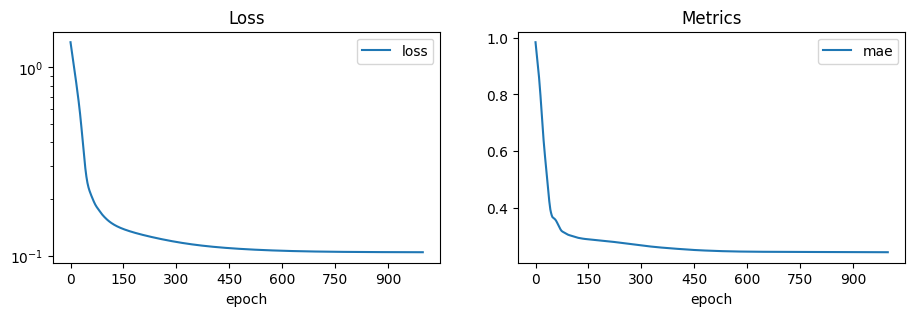

input=(32, 4, 4, 1), output=(32, 2, 2, 2)
y_true[0]: [0.32955897 0.32955897 0.17763178 0.17763178 0.78421557 0.78421557
 2.3789334  2.3789334 ]
y_pred[0]: [0.50874776 0.50447315 0.35010603 0.3498448  0.46651757 0.45239282
 1.888346   1.8833017 ]
error[0]:  [-0.17918879 -0.17491418 -0.17247425 -0.17221303  0.317698    0.33182275
  0.49058747  0.4956317 ]


In [ ]:
# Direct Literal AvePool as a model of MaxPool
def get_model(mode="small"):
  input = tf.keras.Input(shape=(4, 4, 1))
  features = input
  if mode == "big":
    features = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(features)
    features = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(features)
  features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(features)
  out = layers.AveragePooling2D(pool_size=(2,2))(features)
  return tf.keras.Model(inputs=input, outputs=out)

# dataset:
# - expected output is result of simple maxpool against original input
def get_dataset():
  x = tf.random.normal(shape=(32, 4, 4, 1))
  features = layers.Concatenate()([x, x])  # (32, 4, 4, 2)
  y_true = layers.MaxPool2D(pool_size=(2,2))(features)
  return x, y_true

model = get_model("small")
dataset = tf.data.Dataset.from_tensor_slices(get_dataset()).batch(32)
compare_model_efficiency(model, dataset)

print()
model = get_model("big")
dataset = tf.data.Dataset.from_tensor_slices(get_dataset()).batch(32)
compare_model_efficiency(model, dataset)

In [ ]:
# Literal MaxPool against coords
def get_model():
  input = tf.keras.Input(shape=(4, 4, 1))
  features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
  coords = CoordGrid2D()(input)
  data = layers.Concatenate()([features, coords])
  out = PositionwiseMaxPool2D(pool_size=(2,2), channel_weights=[1, 0, 0])(data)
  return tf.keras.Model(inputs=input, outputs=out)

# dataset:
# - expected output is result of simple maxpool against coords
def get_dataset():
  x = tf.random.normal(shape=(32, 4, 4, 1))
  coords = CoordGrid2D()(x)
  data = layers.Concatenate()([x, coords])
  y_true = PositionwiseMaxPool2D(pool_size=(2,2), channel_weights=[1, 0, 0])(data)
  y_true = y_true[..., -2:]
  return x, y_true

model = get_model()
dataset = tf.data.Dataset.from_tensor_slices(get_dataset()).batch(32)
compare_model_efficiency(model, dataset)

ValueError: Exception encountered when calling PositionwiseMaxPool2D.call().

[1mCould not automatically infer the output shape / dtype of 'positionwise_max_pool2d_6' (of type PositionwiseMaxPool2D). Either the `PositionwiseMaxPool2D.call()` method is incorrect, or you need to implement the `PositionwiseMaxPool2D.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 4 and 3 for '{{node mul}} = Mul[T=DT_FLOAT](Square, mul/y)' with input shapes: [?,2,2,4,4], [3].[0m

Arguments received by PositionwiseMaxPool2D.call():
  • args=('<KerasTensor shape=(None, 4, 4, 4), dtype=float32, sparse=False, name=keras_tensor_128>',)
  • kwargs=<class 'inspect._empty'>

Epoch   100 - 15.80ms/epoch: loss: 0.0277  mae: 0.1609  
Epoch   200 - 6.75ms/epoch: loss: 0.0256  mae: 0.1552  
Epoch   300 - 6.15ms/epoch: loss: 0.0242  mae: 0.1504  
Epoch   400 - 6.53ms/epoch: loss: 0.0229  mae: 0.1455  
Epoch   500 - 6.42ms/epoch: loss: 0.0219  mae: 0.1407  
Epoch   600 - 6.91ms/epoch: loss: 0.0211  mae: 0.1365  
Epoch   700 - 8.98ms/epoch: loss: 0.0205  mae: 0.1331  
Epoch   800 - 10.91ms/epoch: loss: 0.0201  mae: 0.1301  
Epoch   900 - 7.99ms/epoch: loss: 0.0197  mae: 0.1276  
Epoch  1000 - 7.54ms/epoch: loss: 0.0194  mae: 0.1254  
Total training time: 8.4 sec


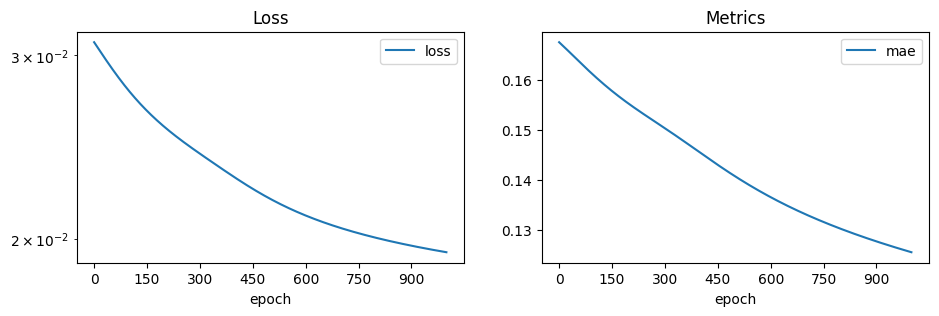

input=(32, 4, 4, 1), output=(32, 2, 2, 2)
y_true[0]: [-0.5        -0.5         0.16666669 -0.16666666 -0.5         0.16666669
  0.16666669  0.5       ]
y_pred[0]: [-0.3167928  -0.3830957   0.23122033 -0.3062971  -0.35651705  0.35967362
  0.3390803   0.337727  ]
error[0]:  [-0.18320721 -0.11690429 -0.06455365  0.13963044 -0.14348295 -0.19300693
 -0.17241362  0.16227299]


In [ ]:
# "Expected Coordinate" via soft-selection (broken down)
def get_model():
  input = tf.keras.Input(shape=(4, 4, 1))
  features = layers.Conv2D(2, kernel_size=(3, 3), padding='same')(input)
  features = StridedSoftmax2D()(features)
  coords = CoordGrid2D()(input)
  out = DotPool2D()(features, coords)
  return tf.keras.Model(inputs=input, outputs=out)

# dataset:
# - expected output is result of simple maxpool against coords
def get_dataset():
  x = tf.random.normal(shape=(32, 4, 4, 1))
  coords = CoordGrid2D()(x)
  data = layers.Concatenate()([x, coords])
  y_true = PositionwiseMaxPool2D(pool_size=(2,2), channel_weights=[1, 0, 0])(data)
  y_true = y_true[..., -2:]
  return x, y_true

model = get_model()
dataset = tf.data.Dataset.from_tensor_slices(get_dataset()).batch(32)
compare_model_efficiency(model, dataset)